#<center> TP 2.1 - Stratégies <center/>
---
---
> But du TP : Implémenter des stratégies trend-following et mean-reverting, les tester sur différents intervalles de temps afin de montrer que les marchés ne sont pas stationnaires, et qu'il faut savoir être adaptatif pour générer de l'alpha dans tous les cas. Puis d'implémenter $3$ stratégies.

In [ ]:
# Import des librairies
!pip install yfinance
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

# Note : Apport du $log$
- On a $$r_{t+1} = \frac{p_{t+1} - p_t}{p_t} \iff p_{t+1} = p_{t}(1+r_{t+1})$$

- Nous avons donc un processus multiplicatif, qui deviendra additif quand on passera au $log$. De plus on peut noter que pour des $\textit{float}$ très petits, la mutiplication peut causer certaines approximations machine.

- Et :
\begin{align*}
p_{t+1} = p_{t}(1+r_{t+1}) \iff \frac{p_{t+1}}{p_t} = 1 + r_{t+1} &\iff \log\left(\frac{p_{t+1}}{p_t}\right) = \log(1 + r_{t+1}) \\
&\iff \log\left(\frac{p_{t+1}}{p_t}\right) \overset{Taylor}{\approx} r_{t+1} \\
&\iff \log(p_{t+1}) = \log(p_t) + r_{t+1}
\end{align*}

- De plus, on a : $$e^{\log\left(\frac{p_{t+1}}{p_t}\right)} - 1 = r_{t+1}$$

- Pour les rendements cumulatifs, on a :
\begin{align*}
r_{tot} = \prod_{i=1}^{N}(1+r_i) &\iff r_{tot} = e^{\log\underset{i}{\overset{N}{\prod}}{(1 + r_i)}} \\
&\iff r_{tot} = e^{\underset{i}{\overset{N}{\sum}}\log(1 + r_i)} \\
&\iff r_{tot} = e^{\underset{i}{\overset{N}{\sum}}\log(\frac{p_i}{p_{i-1}})}
\end{align*}

- Nous considérerons donc toujours des log-prix et des log-rendements.

- Nous allons travailler sur $5$ actifs : 
  - Netflix (tech)
  - PetroChina Company Limited (Oil & Gas)
  - Toyota Motors (Consumer goods)
  - Walt Disney (Consumer services)
  - Medtronic PLC (HealthCare)

- Avec à chaque fois le maximum possible de données

### Prix et log-prix pour Netflix

In [ ]:
netflix =  yf.download("NFLX")
netflix["log_price"] = np.log(netflix["Adj Close"]) # On ajoute le log du prix
netflix["log_r"] = np.log(netflix["Adj Close"]).diff() # log-rendement
netflix["r"] = np.exp(netflix.log_r) - 1 # vrai rendement depuis le log
netflix.dropna(inplace=True)
netflix.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,log_price,log_r,r
Date,,,,,,,,,
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,0.190620,0.011279,0.011343
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,0.145954,-0.044666,-0.043684
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,0.098551,-0.047403,-0.046297
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,0.068993,-0.029558,-0.029125
2002-05-31,1.078571,1.078571,1.071429,1.076429,1.076429,8464400,0.073649,0.004656,0.004667


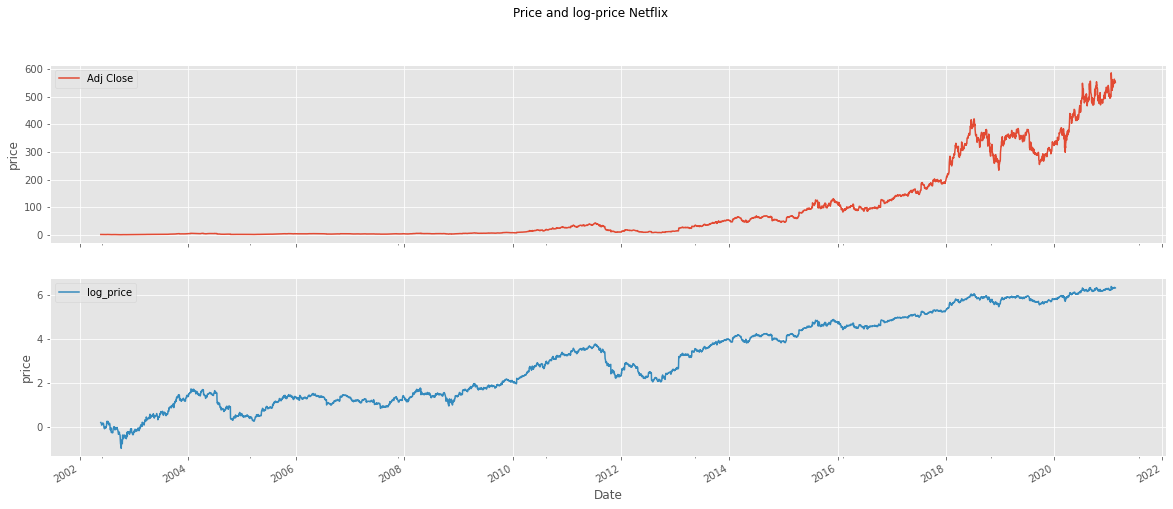

In [ ]:
# Affichage de notre série finanicère pour le prix et le log du prix
netflix.loc[:,["Adj Close", "log_price"]].plot(figsize=(20,8), grid=True, legend=True, title="Price and log-price Netflix", ylabel="price", subplots=True);

### Import des autres actifs

In [ ]:
%%capture
# les 4 autres actifs
names = ["Netflix", "PetroChina", "Toyota Motors", "Walt Disney", "Medtronic PLC"]
petrochina =  yf.download("PTR", history="max")
toyota = yf.download("TM?", history="max")
waltdisney = yf.download("DIS", history="max")
medtronic = yf.download("MDT", history="max")

for asset in [petrochina, toyota, waltdisney, medtronic]:
  asset["log_r"] = np.log(asset["Adj Close"]).diff() # log-rendement
  asset.dropna(inplace=True)
  asset.drop(asset.columns.difference(["Adj Close", "log_r"]), axis=1, inplace=True) # on ne garde que les colonnes qui nous intéressent

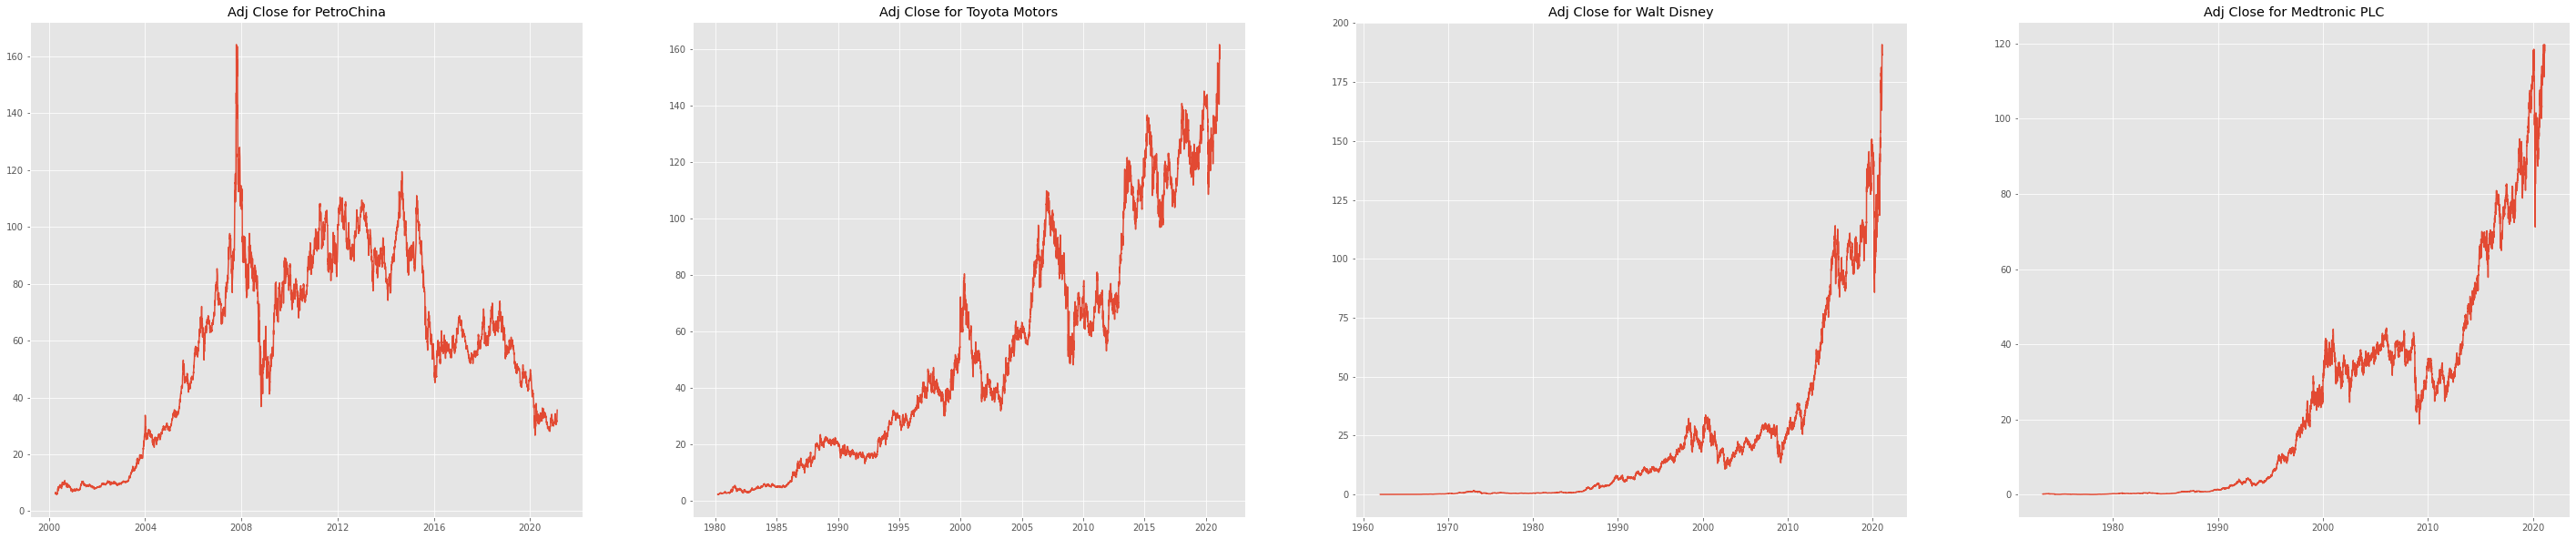

In [ ]:
# On plot les Adj Close des autres actifs
fig, ax = plt.subplots(1,4,figsize=(50,10))
for i, asset in enumerate([petrochina, toyota, waltdisney, medtronic]):
  ax[i].plot(asset[["Adj Close"]])
  ax[i].set_title(f"Adj Close for {names[i+1]}")

---
# 1 - Trend Following : Moyennes mobiles


## 1.1 - Exemple pour $Netflix$ avec $MB^{1}_{30j}$ et $MB^{2}_{90j}$

In [ ]:
netflix["MB_30"] = netflix["Adj Close"].rolling(30).mean()
netflix["MB_90"] = netflix["Adj Close"].rolling(90).mean()
netflix.dropna(inplace=True)

In [ ]:
# On définit notre stratégie
netflix["x"] = 1*(netflix["MB_30"]>netflix["MB_90"]) + -1*(netflix["MB_30"]<netflix["MB_90"])
# On shift x pour ne pas utiliser le futur dans
netflix["x"] = netflix["x"].shift(1)
# Notre nouvel asset gt = x_t*r_t
netflix["g"] = netflix.x * netflix.log_r
# Entry lorsque on change de posiitons
netflix["entry"] = 1*(netflix.x != netflix.x.shift(1))
netflix.dropna(inplace=True)
netflix

,Open,High,Low,Close,Adj Close,Volume,log_price,log_r,r,MB_30,MB_90,x,g,entry
Date,,,,,,,,,,,,,,
2002-10-02,0.688571,0.688571,0.560714,0.578571,0.578571,9314200,-0.547194,-0.159428,-0.147368,0.843667,0.961889,-1.0,0.159428,1
2002-10-03,0.569286,0.570000,0.489286,0.517857,0.517857,9765000,-0.658056,-0.110862,-0.104938,0.828643,0.954786,-1.0,0.110862,0
2002-10-04,0.517857,0.531429,0.447143,0.468571,0.468571,8433600,-0.758068,-0.100012,-0.095173,0.811476,0.947730,-1.0,0.100012,0
2002-10-07,0.450000,0.458571,0.382143,0.412143,0.412143,15724800,-0.886385,-0.128317,-0.120426,0.792095,0.940405,-1.0,0.128317,0
2002-10-08,0.410714,0.427857,0.390714,0.405000,0.405000,4531800,-0.903868,-0.017483,-0.017331,0.773333,0.932944,-1.0,0.017483,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-10,562.500000,566.650024,553.460022,563.590027,563.590027,3991300,6.334327,0.008052,0.008085,533.529666,514.763443,1.0,0.008052,0
2021-02-11,564.440002,565.929993,554.219971,557.590027,557.590027,2726700,6.323624,-0.010703,-0.010646,534.420334,515.369332,1.0,-0.010703,0
2021-02-12,556.940002,561.250000,550.849976,556.520020,556.520020,2195900,6.321703,-0.001921,-0.001919,535.484667,515.767888,1.0,-0.001921,0


### Entries de 2017 à aujourd'hui

In [ ]:
# Fonction permettant de plot les entries
def plot_entries(data, columns, strat_title="?", plot_exits=False):
  data.loc[:,columns].plot(figsize=(25,10), grid=True, title=f"Entries for {strat_title} strategy");
  plt.scatter(data.index[(data.x==1) & (data.entry==1)], data[(data.x==1) & (data.entry==1)]["Adj Close"], marker="^", color='green', s=100, label="Long")
  plt.scatter(data.index[(data.x==-1) & (data.entry==1)], data[(data.x==-1) & (data.entry==1)]["Adj Close"], marker="v", color='red', s=100, label="Short");
  if plot_exits: plt.scatter(data.index[(data.x==0) & (data.entry==1)], data[(data.x==0) & (data.entry==1)]["Adj Close"], marker="|", color='black', s=100, label="Exit");
  # if plot_exits: plt.vlines(data.index[(data.x==0) & (data.entry==1)], 0,600, linestyles="--", linewidth=0.7);
  plt.legend()

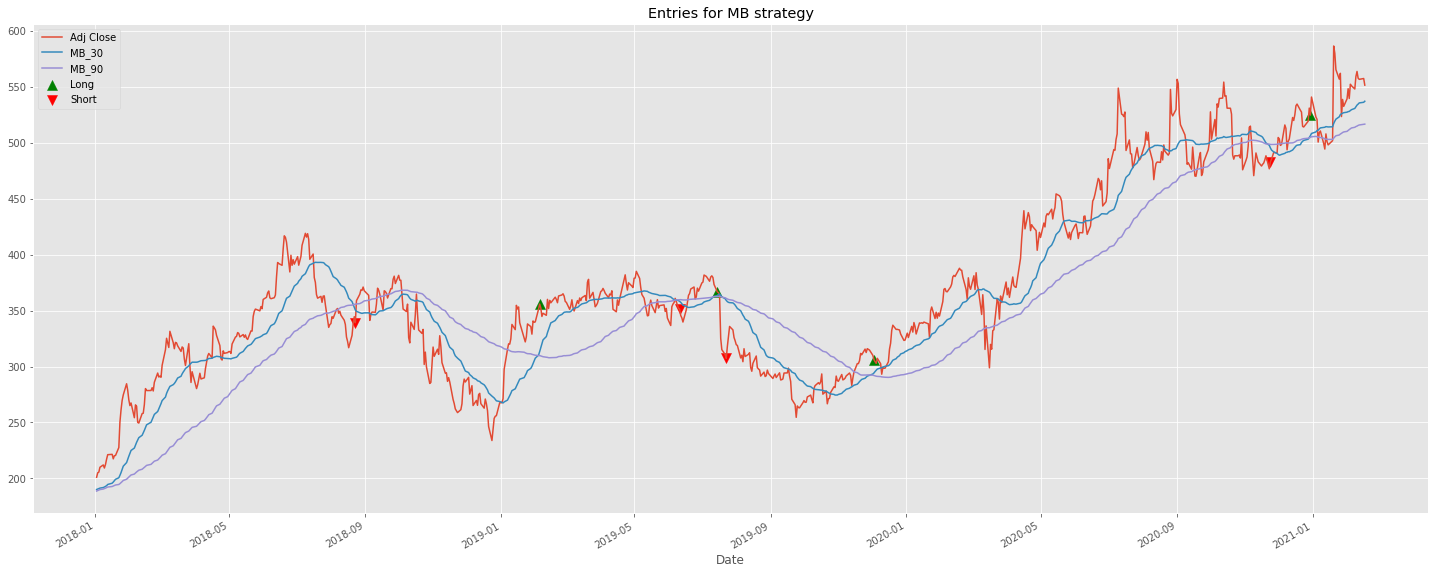

In [ ]:
plot_entries(netflix.loc["2018":],["Adj Close", "MB_30", "MB_90"], strat_title="MB")

- Nous avons donc une vue sur nos entrées en position, nous voyons bien une position short lorsque la moyenne mobile de plus longue période passe au dessus de celle de plus courte période, et vice-versa.

## 1.2 - Grilles de performances 

- Nous calculons les performances des stratégies pour chaque couple $MB_1, MB_2$ de périodes $\in [10,1000]_{step=10}$ avec $period_2 < period_1$ à chaque itération, et pour chaque actifs.

- Nous prenons la $\textit{t-stat}$ comme mesure de performance : $$\sqrt{n}\frac{\mu}{\sigma}$$

In [ ]:
def grid_perf_MB(data, maxperiod=1000, step=10):
  all_periods = np.arange(10, maxperiod+step, step)
  perfs = np.zeros((len(all_periods), len(all_periods)))
  # On boucle sur les moyennes mobiles
  for i, period in enumerate(all_periods):
    MB1 = data["Adj Close"].rolling(period).mean()
    for j, lag in enumerate(range(10,period,step)):
      MB2 = data["Adj Close"].rolling(lag).mean()
      x = 1*(MB2 > MB1) + -1*(MB2 < MB1)
      x = x.shift(1)
      # On le calcule sur les logs rendeements
      g = data["log_r"]*x
      # On ne prends que les rendements != 0
      g = g[g!=0]
      # On ne prend pas en compte les NaN
      perfs[i,j] = np.nanmean(g)/np.std(g.dropna())*np.sqrt(len(g.dropna())) # t-stat
      # perfs[i, j] = np.exp(g.cumsum()[-1]) - 1
  return perfs

In [ ]:
# On load la performances pour nos 5 actifs
perfs_netf = grid_perf_MB(netflix, maxperiod=1000, step=10)
perfs_petr = grid_perf_MB(petrochina, maxperiod=1000, step=10)
perfs_toy = grid_perf_MB(toyota, maxperiod=1000, step=10)
perfs_walt = grid_perf_MB(waltdisney, maxperiod=1000, step=10)
perfs_med = grid_perf_MB(medtronic, maxperiod=1000, step=10)

## 1.3 - Heatmap

- Nous allons plot le heatmap des performances en fonction des différentes périodes des $MB$, pour nos $5$ actifs.

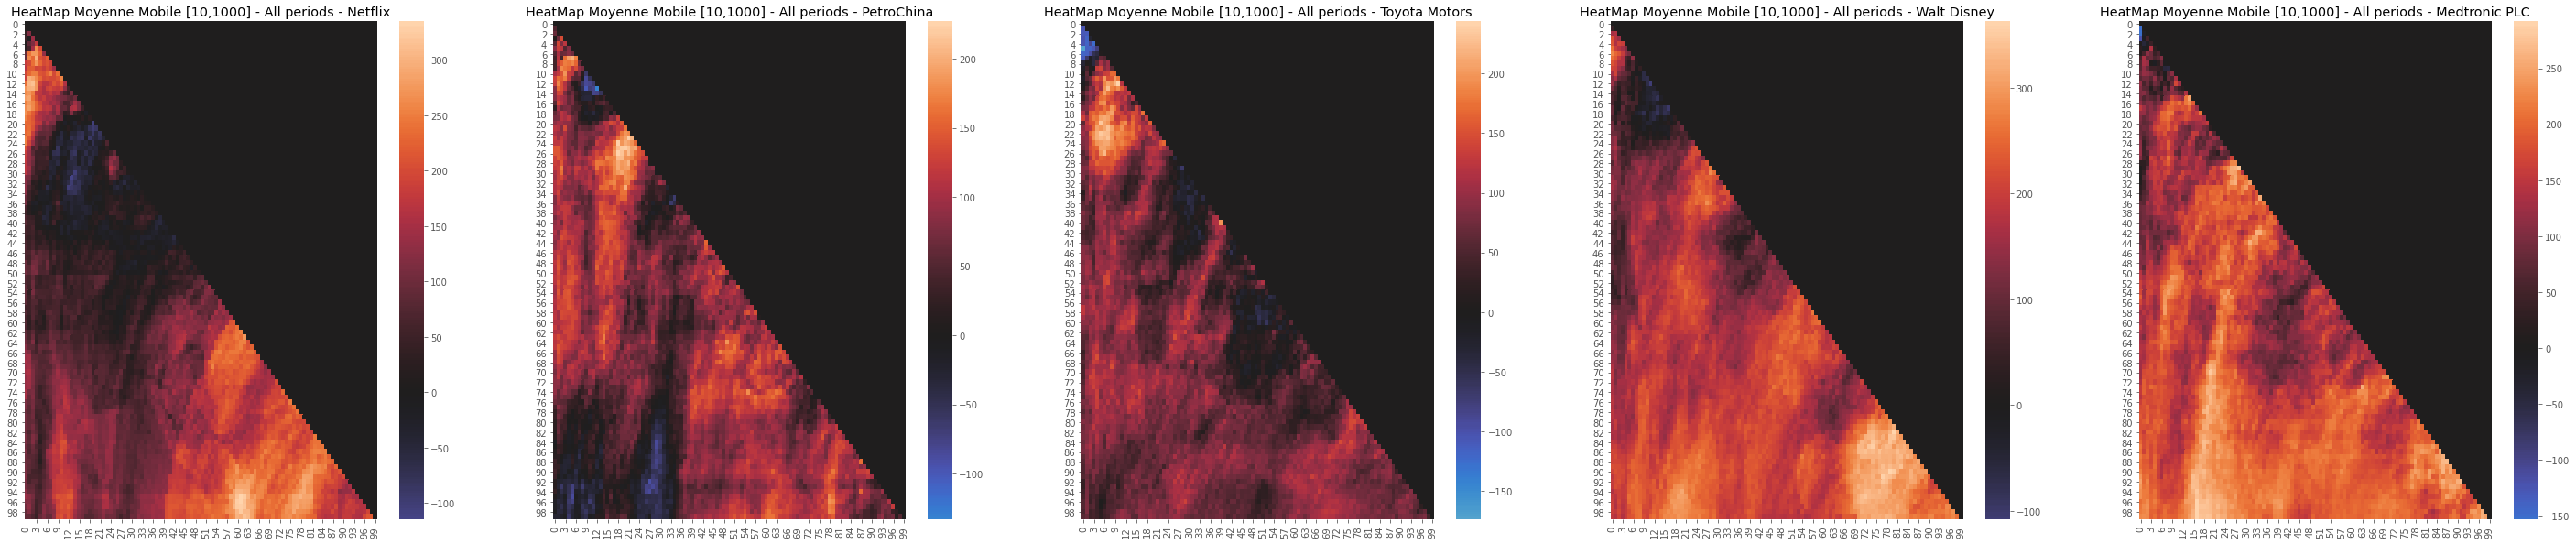

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(50,10)) # on plot en ligne 
ax.ravel()
for i, asset in enumerate([netflix, petrochina, toyota, waltdisney, medtronic]):
  perf = grid_perf_MB(asset, maxperiod=1000, step=10)
  sns.heatmap(perf*100, center=0, ax=ax[i]);
  ax[i].set_title(f"HeatMap Moyenne Mobile [10,1000] - All periods - {names[i]}");

- Nous voyons donc que la stratégie de trend following est plus profitable pourn les actifs avec une tendance : Netlfix, Walt Disney et Medtronic.

## 1.4 - Test de la stratégie sur deux périodes

Ici nous allons tester exactement la même stratégie avec les mêmes paramètres mais sur deux périodes différentes de nos jeux de données : avant et après la moitié des données que nous avons.

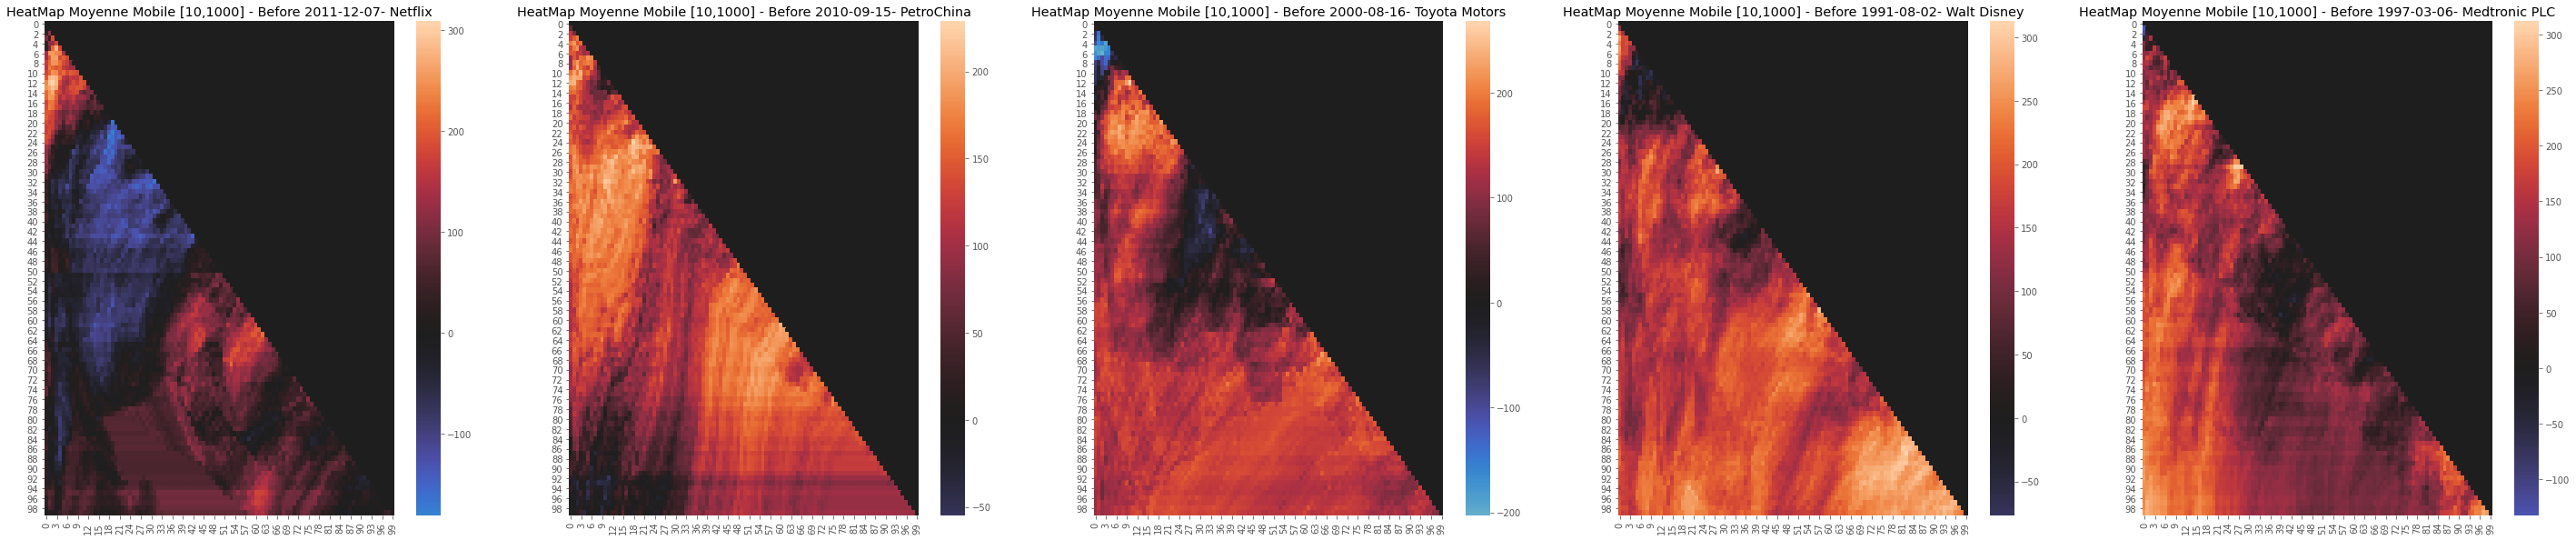

In [ ]:
# Première moitié des données
fig, ax = plt.subplots(1,5, figsize=(50,10)) # on plot en ligne 
ax.ravel()
for i, asset in enumerate([netflix, petrochina, toyota, waltdisney, medtronic]):
  thresold = int(asset.shape[0]/2)
  perfs_before = grid_perf_MB(asset.iloc[:thresold], maxperiod=1000, step=10)
  sns.heatmap(perfs_before*100, center=0, ax=ax[i]);
  ax[i].set_title(f"HeatMap Moyenne Mobile [10,1000] - Before {str(asset.index[thresold].date())}- {names[i]}");

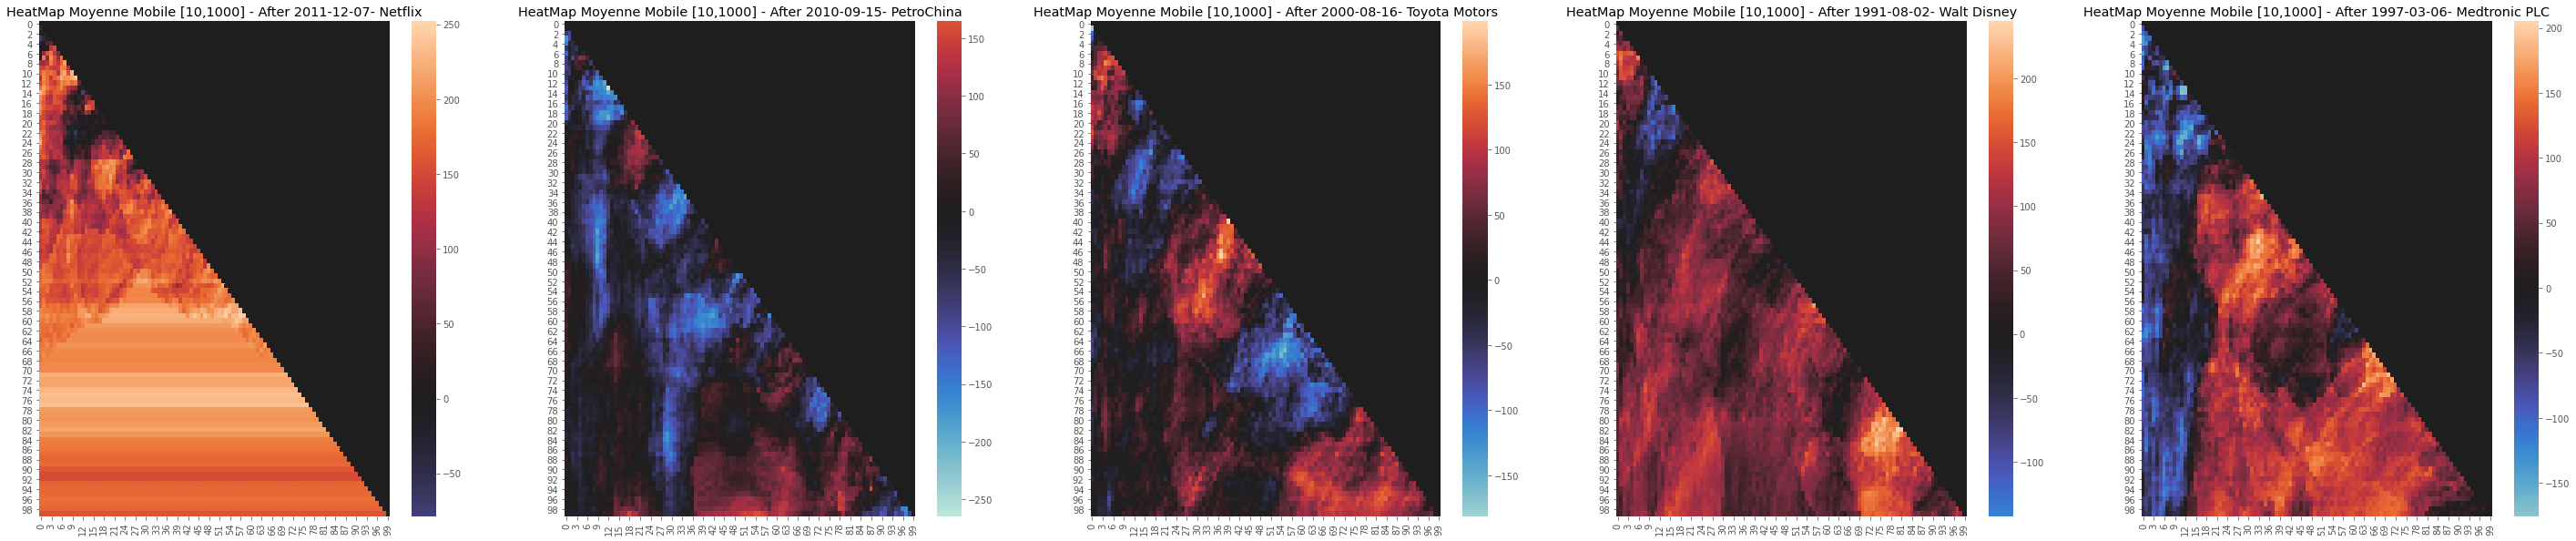

In [ ]:
# Deuxième moitié des données
assets = [netflix, petrochina, toyota, waltdisney, medtronic]
fig, ax = plt.subplots(1,5, figsize=(50,10)) # on plot en ligne 
ax.ravel()
for i, asset in enumerate([netflix, petrochina, toyota, waltdisney, medtronic]):
  thresold = int(asset.shape[0]/2)
  perfs_before = grid_perf_MB(asset.iloc[thresold:], maxperiod=1000, step=10)
  sns.heatmap(perfs_before*100, center=0, ax=ax[i]);
  ax[i].set_title(f"HeatMap Moyenne Mobile [10,1000] - After {str(asset.index[thresold].date())}- {names[i]}");

- Par exemple pour Netflix : 
  - Plus haut, sur les prix tracés de l'action $Netflix$ depuis 2002, nous voyons clairement qu'il n'y a aucune tendance jusqu'à notre seuil (2011).

  - Puis, en deuxième moité, une forte tendance haussière dûe biensur à cette arrivée du streaming dans notre quotidien.

  - Le heatmap corresponant à la première partie de notre période (2002-2011) pour notre stratégie de trend following ne porte donc clairement pas ses fruits, ce qui est cohérent avec le fait que les stratégies de moyennes mobiles sont connues pour être inefficaces en période de range.

  - Inversement, la tendance haussière de la deuxième période (2011-présent) est bien en accord avec le heatmap que nous otenons ci-dessus. 

  - Sans surprise, notre heatmap général sur toutes les périodes est une aggrégation des deux.

- Nous pourrions faire un raisonnement similaire pour les $4$ autres actifs.
  - Où en général les performances de la deuxième moitié sont bien moins bonnes que pour la première moitié, où les actifs ont une légère tendance haussière sans grosses variations.

- Nous pouvons donc assurer que la stratégie n'est pas stationnaire, car les graphes ne sont pas du tout constant entre les première et deuxième parties de notre période.

- Remarque : On voit quand même que pour un moyenne mobile longue d'a peu près 100 jours et une courte d'environ 30 jours, les perfomances semblent stables et bonnes, mais cela est surement lié à la particularité de trend haussière de l'actif Netflix.

# 2 - Mean-reverting

## 2.1 - Exemple pour $Netflix$ avec $MB_{50j}$, $\sigma_{50j}$ et $K=0.5$ 

In [ ]:
# On retélécharge pour avoir les premiers jours
netflix =  yf.download("NFLX")
netflix["log_r"] = np.log(netflix["Adj Close"]).diff()
# netflix["r"] = np.exp(np.log(netflix["Adj Close"]).diff()) - 1
netflix.dropna(inplace=True)

netflix["MB_50"] = netflix["Adj Close"].rolling(50).mean()
netflix["STD_50"] = netflix["Adj Close"].rolling(50).std()
netflix.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
K = 1
# On définit notre stratégie
netflix["x"] = 1*(netflix["Adj Close"] < netflix["MB_50"] - netflix["STD_50"]*K) + -1*(netflix["Adj Close"] > netflix["MB_50"] + netflix["STD_50"]*K)
# On fixe à 0 quand le prix croise la moyenne mobile
# netflix.loc[(netflix["MB_50"] < 20), "x"] = 0
# On shift x pour ne pas utiliser le futur dans
netflix["x"] = netflix["x"].shift(1)
# Notre nouvel asset gt = x_t*r_t
netflix["g"] = netflix.x * netflix.log_r
# Entry lorsque on change de positions
netflix["entry"] = 1*(netflix.x != netflix.x.shift(1))
netflix.dropna(inplace=True)
netflix

,Open,High,Low,Close,Adj Close,Volume,log_r,MB_50,STD_50,x,g,entry
Date,,,,,,,,,,,,
2002-08-06,0.795714,0.803571,0.742857,0.760714,0.760714,3217200,-0.018606,1.055900,0.127502,1.0,-0.018606,1
2002-08-07,0.760714,0.793571,0.742857,0.793571,0.793571,2758000,0.042286,1.048629,0.131901,1.0,0.042286,0
2002-08-08,0.796429,0.803571,0.750714,0.796429,0.796429,2283400,0.003595,1.042486,0.136367,1.0,0.003595,0
2002-08-09,0.798571,0.821429,0.778571,0.787143,0.787143,1500800,-0.011728,1.036800,0.140984,1.0,-0.011728,0
2002-08-12,0.802857,0.807143,0.753571,0.757143,0.757143,2130800,-0.038858,1.030414,0.146283,1.0,-0.038858,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-10,562.500000,566.650024,553.460022,563.590027,563.590027,3991300,0.008052,525.298400,23.874498,-1.0,-0.008052,0
2021-02-11,564.440002,565.929993,554.219971,557.590027,557.590027,2726700,-0.010703,526.636200,23.770075,-1.0,0.010703,0
2021-02-12,556.940002,561.250000,550.849976,556.520020,556.520020,2195900,-0.001921,527.675001,23.920966,-1.0,0.001921,0


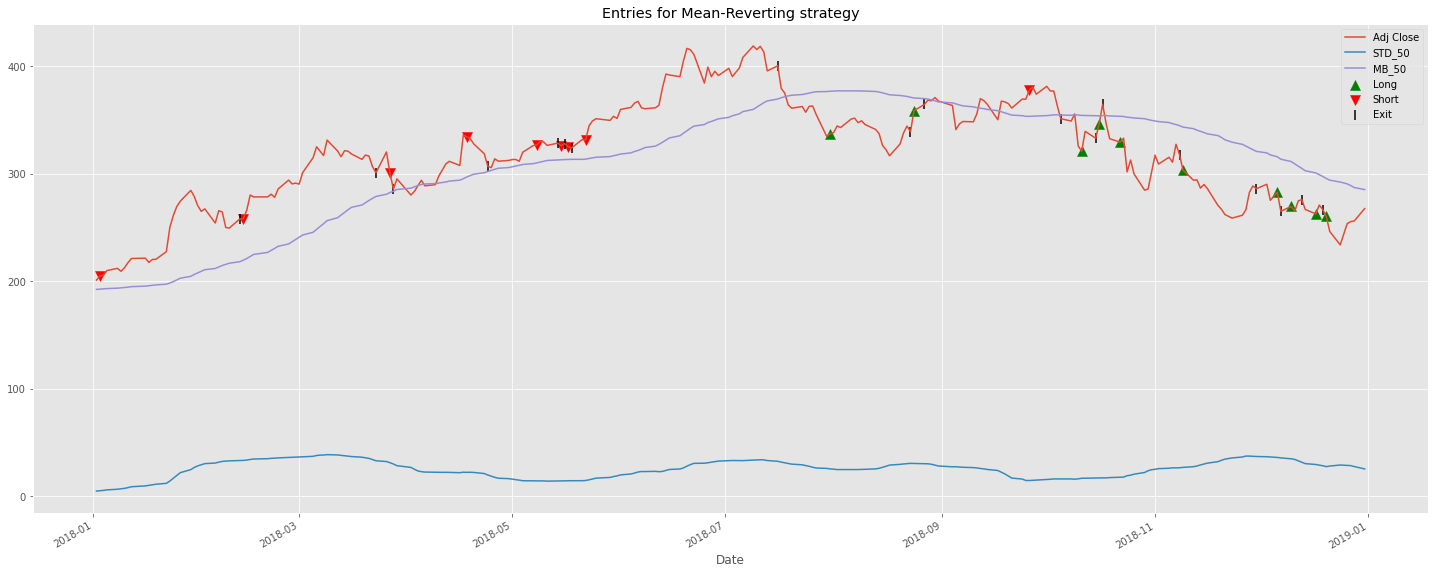

In [ ]:
plot_entries(netflix.loc["2018"],["Adj Close", "STD_50", "MB_50"], strat_title="Mean-Reverting", plot_exits=True)

- Nous pouvons vérifier que les positions de vente n'arrivent que lorsque le prix est au dessus de la moyenne mobile, et que les positions d'achat sont lorsque le prix est en dessous, nous sommes donc bien dans un cas de retour à la moyenne.

## 2.2 - Grilles de performances et Heatmaps

In [ ]:
def grid_perf_MeanReverting(data, maxperiod=1000, step=10, coeffs = np.arange(0.05,1.05,0.05), return_periods=False):
  all_periods = np.arange(10, maxperiod+step, step)
  perfs = np.zeros((len(all_periods), len(coeffs)))
  # On boucle en calculant la moyenne mobile et la std pour une période T
  for i, period in enumerate(all_periods):
    MB = data["Adj Close"].rolling(period).mean()
    STD = data["Adj Close"].rolling(period).std()
    # On calcule les performances pour chaque coeff
    for j, coeff in enumerate(coeffs):
      x = 1*(data["Adj Close"] < MB - STD*coeff) + -1*(data["Adj Close"] > MB + STD*coeff)
      x = x.shift(1)
      # On le calcule sur les logs rendeements
      g = data["log_r"]*x
      # On ne prends que les rendements != 0
      g = g[g!=0]
      # On ne prend pas en compte les NaN et les moments ou nous n'avons pas de positions
      perfs[i,j] = np.nanmean(g)/np.std(g.dropna())*np.sqrt(len(g.dropna())) # t-stat
      # perfs[i, j] = np.exp(g.cumsum()[-1]) - 1
  return perfs

### Tests sur toute la période

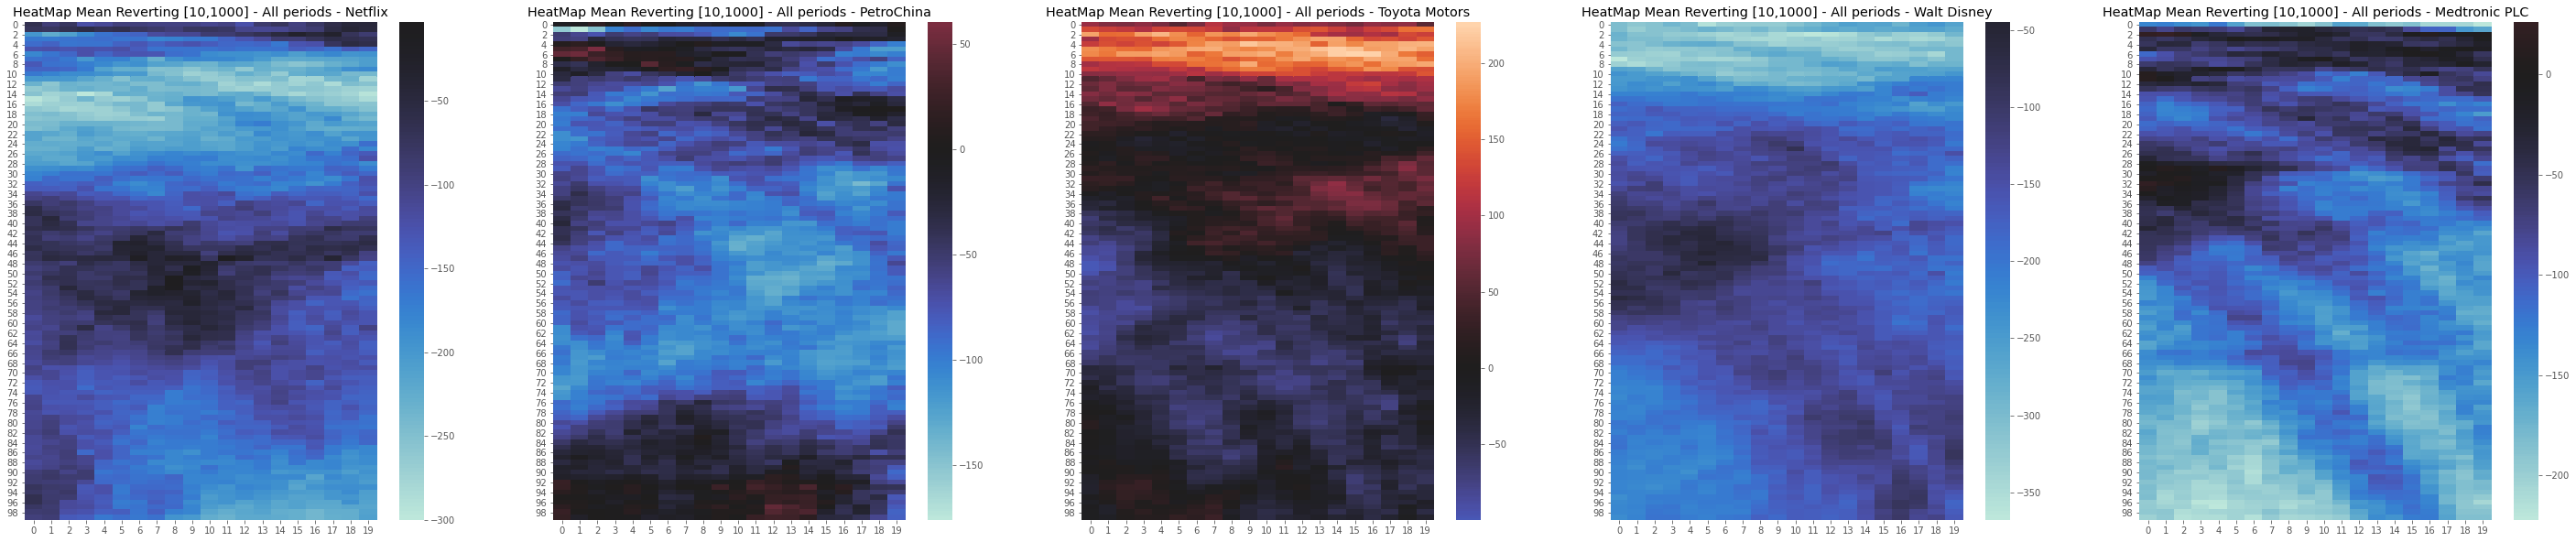

In [ ]:
fig, ax = plt.subplots(1,5, figsize=(50,10)) # on plot en ligne 
ax.ravel()
for i, asset in enumerate([netflix, petrochina, toyota, waltdisney, medtronic]):
  perf = grid_perf_MeanReverting(asset, maxperiod=1000, step=10)
  sns.heatmap(perf*100, center=0, ax=ax[i]);
  ax[i].set_title(f"HeatMap Mean Reverting [10,1000] - All periods - {names[i]}");

### Tests sur les deux périodes

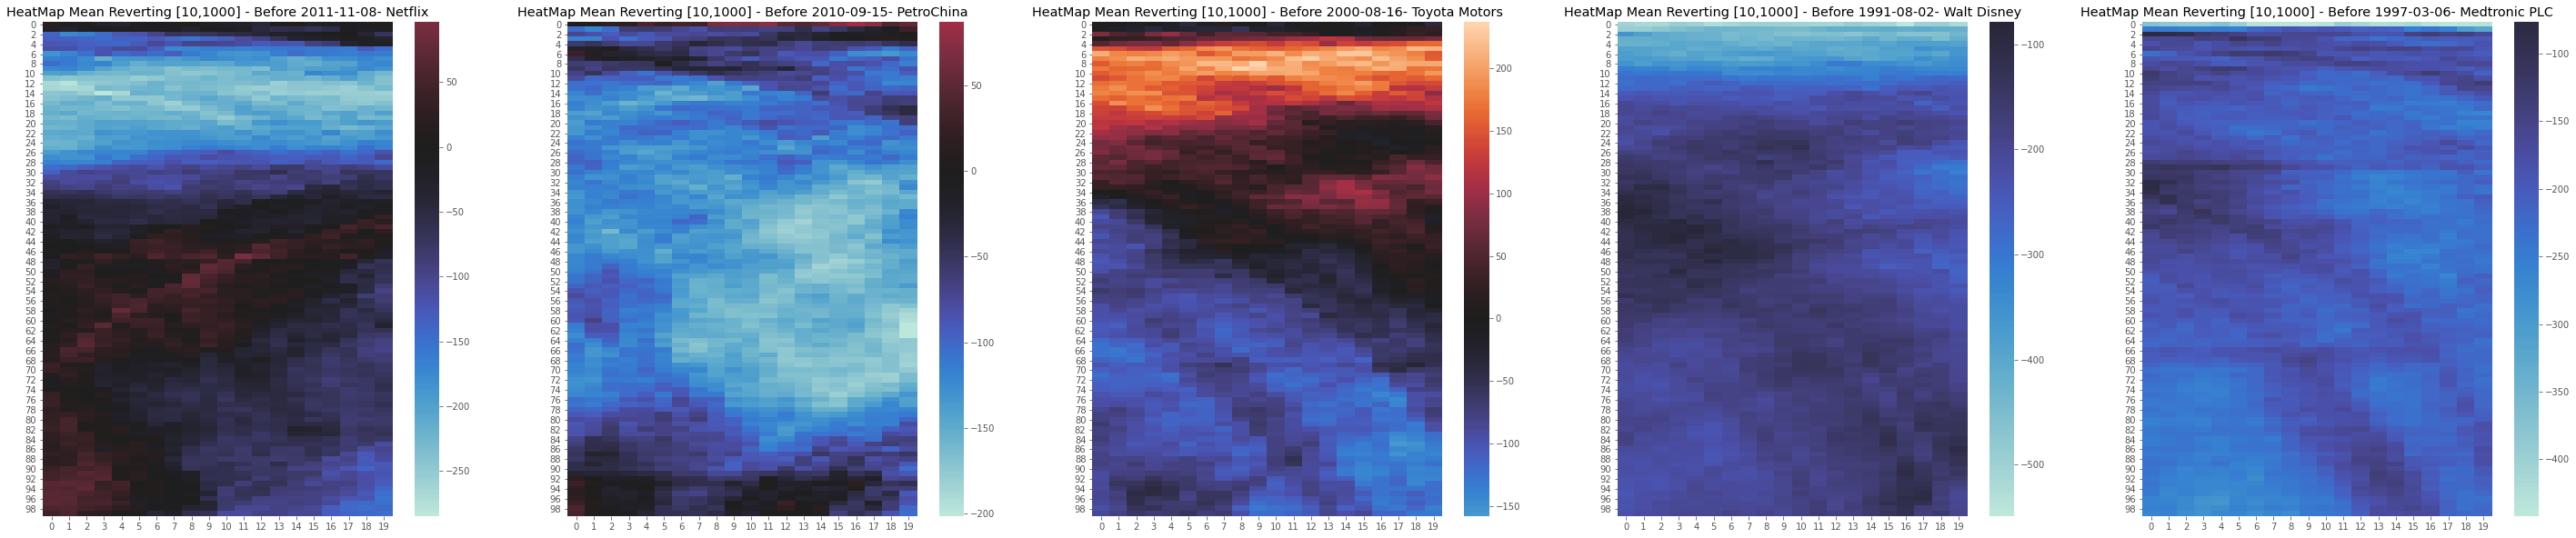

In [ ]:
# Première moitié des données
fig, ax = plt.subplots(1,5, figsize=(50,10)) # on plot en ligne 
ax.ravel()
for i, asset in enumerate([netflix, petrochina, toyota, waltdisney, medtronic]):
  thresold = int(asset.shape[0]/2)
  perfs_before = grid_perf_MeanReverting(asset.iloc[:thresold], maxperiod=1000, step=10)
  sns.heatmap(perfs_before*100, center=0, ax=ax[i]);
  ax[i].set_title(f"HeatMap Mean Reverting [10,1000] - Before {str(asset.index[thresold].date())}- {names[i]}");

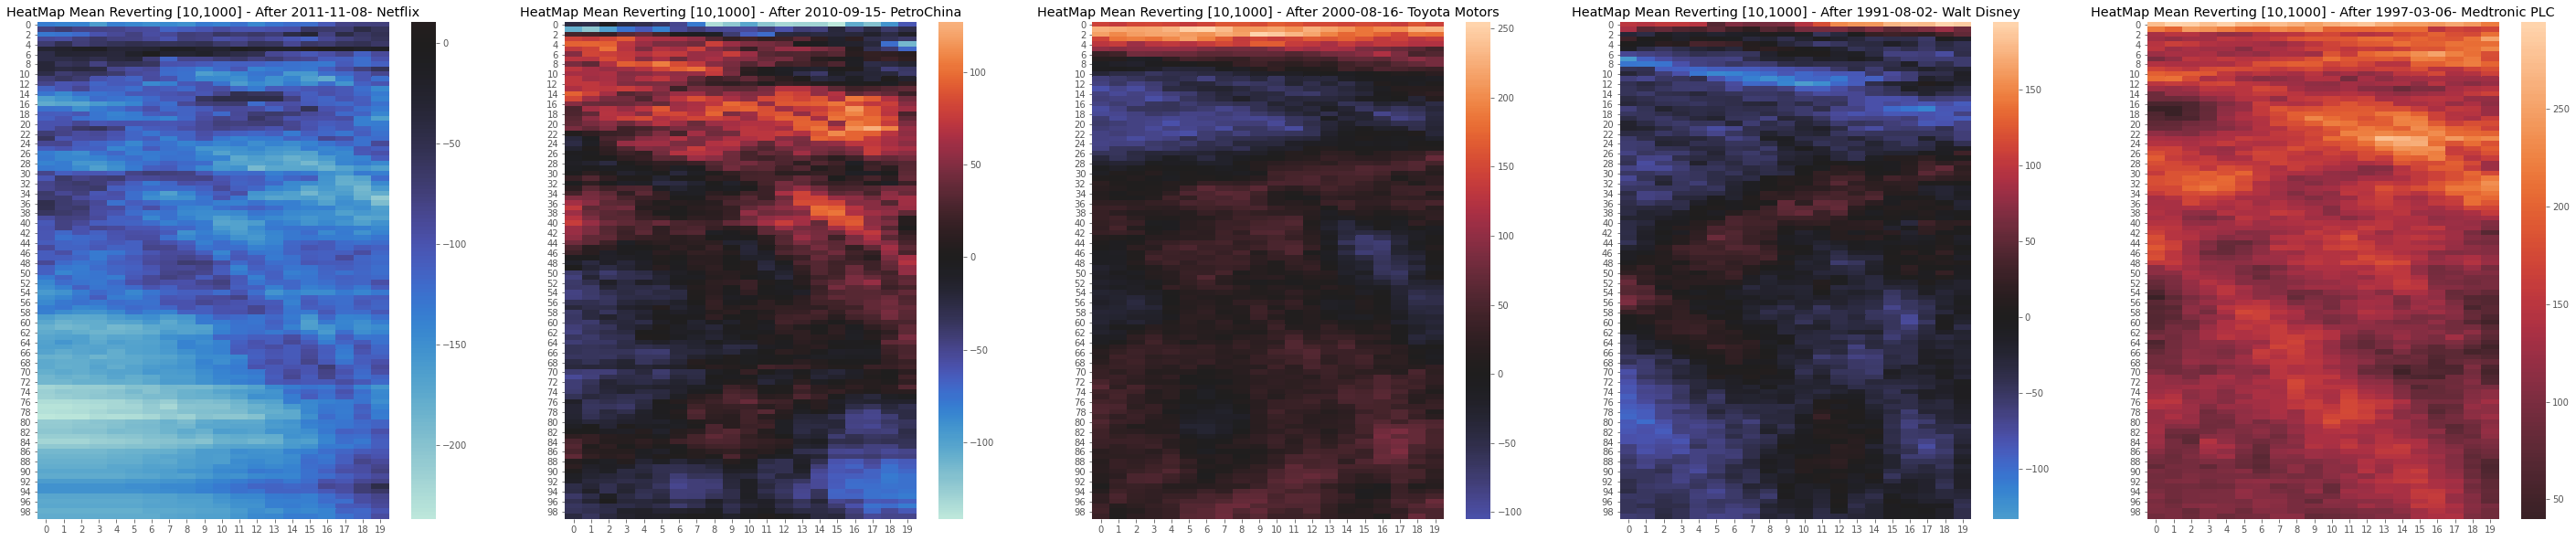

In [ ]:
# Deuxième moitié des données
assets = [netflix, petrochina, toyota, waltdisney, medtronic]
fig, ax = plt.subplots(1,5, figsize=(50,10)) # on plot en ligne 
ax.ravel()
for i, asset in enumerate([netflix, petrochina, toyota, waltdisney, medtronic]):
  thresold = int(asset.shape[0]/2)
  perfs_before = grid_perf_MeanReverting(asset.iloc[thresold:], maxperiod=1000, step=10)
  sns.heatmap(perfs_before*100, center=0, ax=ax[i]);
  ax[i].set_title(f"HeatMap Mean Reverting [10,1000] - After {str(asset.index[thresold].date())}- {names[i]}");

- Inversement au trend following, nous vérifions que notre stratégie est meilleure sur les périodes de range
  - pour Netflix, la stratégie est plus performante en première moitié quand il n'y a pas clairement de trend, mais biens moins quand la trend haussière est clairment visible en deuxième moitié
  - pour PetroChina, la stratégie est plus profitable en deuxième moitié de période, où il n'y pas a de tendances clairement définie et plutot du range
  - pour Medtronic la stratégie est est clairement meilleure en seconde moitié de période, cela peut paraitre assez surprenant au vu de la trend fortement haussière vers 2015 et le fait que l'actif a a peu près la même dynamique que celui de Walt Disney, qui n'affiche pas une performance telle en seconde période. Mais nous voyons quand même pour ces deux actifs que la stratégie n'est pas performante sur la première période, ou il n'y a pas beaucoup de fluctuations mais surtout une tendance légèrement haussière.

- Nous vérifions donc dire que cette stratégie performe en temps de range, ou il n'y a pas de tendance.

- A part pour Toyota, on ne peut pas dire que cette stratégie soit stable non plus.

# 3 - Inventer 3 stratégies

## Stratégie 1 - Google Trend

- Nous allons essayer d'avoir, par jour, un score du nombre de recherches dans le monde entier de l'actif $Netflix$ sur Google, avec notre stratégie qui sera telle que :
  - $x_t = 1$ si le nombre de recherche est supérieur à un certain seuil ($Score = 50$), 
  - $x_t = 0$ (déboucler la position) si le score passe en dessous. 

- Ainsi on aura $g_t = x_{t}r_{t+1}$, et nous choisissons de prendre le log-rendements.

- Notre actif étant Netflix, un site de streaming, nous nous sommes dis qu'une trend haussière pourrait être fortement corrélée à une augmentation du nombre de recherches google.

- Les données Google Trend ne sont accessibles que par mois dans notre cas avec le max historique, nous allons donc garder le même score pour chaque jour du mois en cours. Cette technique de trend-following est donc très discrétionnaire, et nous ne considérons pas de positions short ici.

- Note : 
  - Nous utilisons la librairie $\textit{pytrends}$ pour cela, librairie non officielle (fonctionnant tant que Google ne change pas son Backend).
  - Les scores reflètent la proportion de recherches $Netflix$ sur Google donné dans le monde entier et pour tous les mois depuis le 01-01-2004, par rapport au mois où le taux d'utilisation de ce mot clé est le plus élevé (valeur de 100). Ainsi, une valeur de 50 signifie que le mot clé a été utilisé moitié moins souvent le mois correspondant, et une valeur de 0 signifie que les données pour ce mot clé sont insuffisantes (pas de score à 0 dans notre cas).

In [ ]:
# !pip install pytrends
from pytrends.request import TrendReq

In [ ]:
#-------------------Données-----------------------------
pytrend = TrendReq()
# On requête toutes les données disponibles sur netflix depuis Google Trend
pytrend.build_payload(kw_list=["Netflix"], timeframe="all")
# On load la fonctionnalité "Interest Over Time"
net_interest = pytrend.interest_over_time()
# On resample pour tous les jours - chaque jour aura le score du mois en cours
net_interest = net_interest.resample("D").fillna(method="ffill").rename({"Netflix":"GoogleTrendScore"}, axis=1).drop("isPartial", axis=1)

# On reload nos données de prix netflix
netflix =  yf.download("NFLX");
netflix["log_r"] = np.log(netflix["Adj Close"]).diff()

# On join les deux données
netflix = netflix.join(net_interest)
# On supprime les NaN (les données partiront donc du 01/01/2004)
netflix.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


### Exemple avec un seuil de $Score = 50$

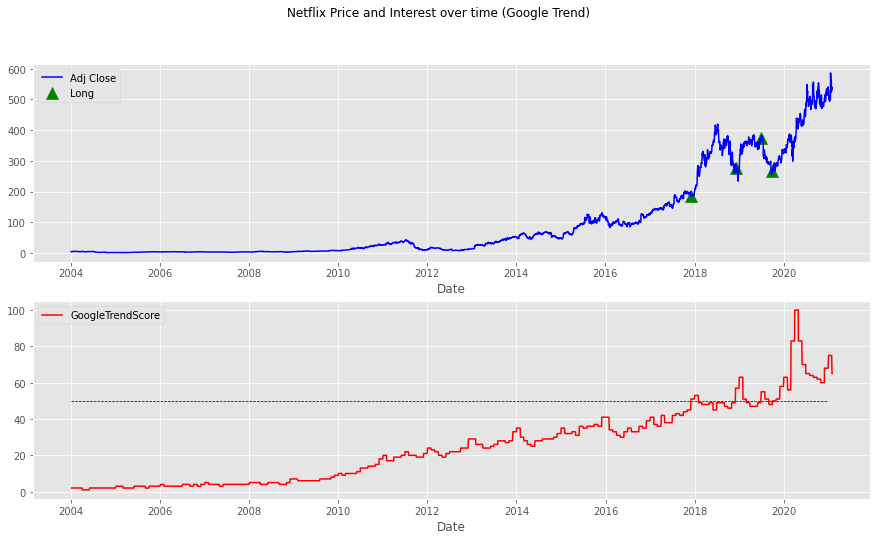

In [ ]:
#-------------------Stratégie----------------------------
# Nos positions
netflix["x"] = 1*(netflix.GoogleTrendScore >= 50)
# On shift
netflix["x"] = netflix["x"].shift(1)
# Notre stratégie
netflix["g"] = netflix.x * netflix.log_r
# Nos entrée
netflix["entry"] = 1*(netflix.x != netflix.x.shift(1))
netflix.dropna(inplace=True)

#----------------------Plot-------------------------------
fig, ax = plt.subplots(2,1, figsize=(15,8))
netflix.loc[:,["Adj Close", "GoogleTrendScore"]].plot(figsize=(15,8), subplots=True, grid=True, color=["blue", "red"], title="Netflix Price and Interest over time (Google Trend)", ax=ax);
ax[1].hlines(50,xmin="2004", xmax="2021", linestyle="--", linewidth=0.7)
ax[0].scatter(netflix.index[(netflix.x==1) & (netflix.entry==1)], netflix[(netflix.x==1) & (netflix.entry==1)]["Adj Close"], marker="^", color='green', s=150, label="Long")
ax[0].legend()

- On vérifie donc bien les entrées à l'achat lorsque le score est supérieur à $50$. 

- De plus, nous voyons bien que les deux trends sont corrélées. 

- Une limite de cette méthode peut être vue directement ici : 
  - Nous voyons bien que la recherche attend le score maximum de $100$ lors du premier confinement mondial, et qu'au même moment l'action $Netflix$ subie une légère baisse du à la crise du Coronavirus. Cela donne donc une limite à cette stratégie. 

In [ ]:
def grid_perf_GoogleTrend(data, seuils = np.arange(10,101)):
  perfs = np.zeros(len(seuils))
  # On boucle avec un score différent pour chaque 
  for i, seuil in enumerate(seuils):
    x = 1*(data.GoogleTrendScore >= seuil)
    x = x.shift(1)
    # On le calcule sur les logs rendeements
    g = data.log_r*x
    # On ne prends que les rendements != 0
    g = g[g!=0]
    g.dropna(inplace=True)
    perfs[i] = np.nanmean(g)/np.std(g)*np.sqrt(len(g)) # t-stat
    # perfs[i] = np.nanmean(g)
  return perfs

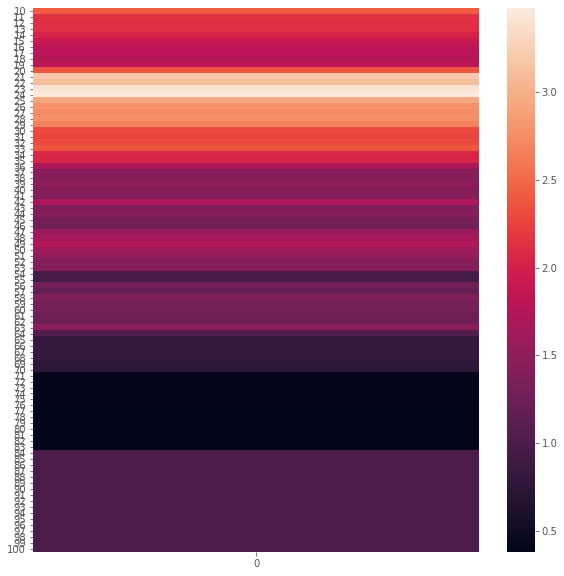

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
perfs = grid_perf_GoogleTrend(netflix)
sns.heatmap(perfs.reshape(len(perfs),1), yticklabels=np.arange(10,101), ax=ax);

- Nous voyons donc que la stratégie est toujours profitable, et d'autant plus lorsque le seuil est bas, ce qui est logique au vu de la tendance haussière de l'actif $Netflix$.

## Stratégie 2 - 

Dans le cadre de cette stratégie nous allons utiliser des réseaux de neurones recurrents pour prédire les rendements et utiliser leurs signe comme des signaux d'achat et de vente.

- Nous utilsons un LSTM Multi-couches pour predire les rendements du Stock "Netflix . Pour tirer partie du LSTM au maximum nous avons recalibrons le LSTM pour chaque pas de temps et generer un backtest correspondant à Algortihme recalibré tous les jours.

- Notre strategie axée autour des rendements utilise le signe les prediction à $t+1$. Si le rendement prédit est positif alors c est un signal d'achat ,et dans le cas contraire c est un signal qui nous indique de sortir de la position.

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

In [ ]:
TICKER = "NFLX"
Stock = yf.download(TICKER) ; Stock = Stock.dropna()
asset_log_returns = pd.DataFrame(data = np.log(Stock['Adj Close']).diff().dropna())
Stock = Stock.drop(Stock.index[0], axis=0) ; 
Stock['returns'] = asset_log_returns.values
print('Number of rows and columns:', Stock.shape)
Stock


[*********************100%***********************]  1 of 1 completed
Number of rows and columns: (4718, 7)


,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,0.011279
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,-0.044666
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,-0.047403
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,-0.029558
2002-05-31,1.078571,1.078571,1.071429,1.076429,1.076429,8464400,0.004656
...,...,...,...,...,...,...,...
2021-02-12,556.940002,561.250000,550.849976,556.520020,556.520020,2195900,-0.001921
2021-02-16,557.289978,563.630005,552.729980,557.280029,557.280029,2622400,0.001365
2021-02-17,550.989990,555.250000,543.030029,551.340027,551.340027,2069600,-0.010716


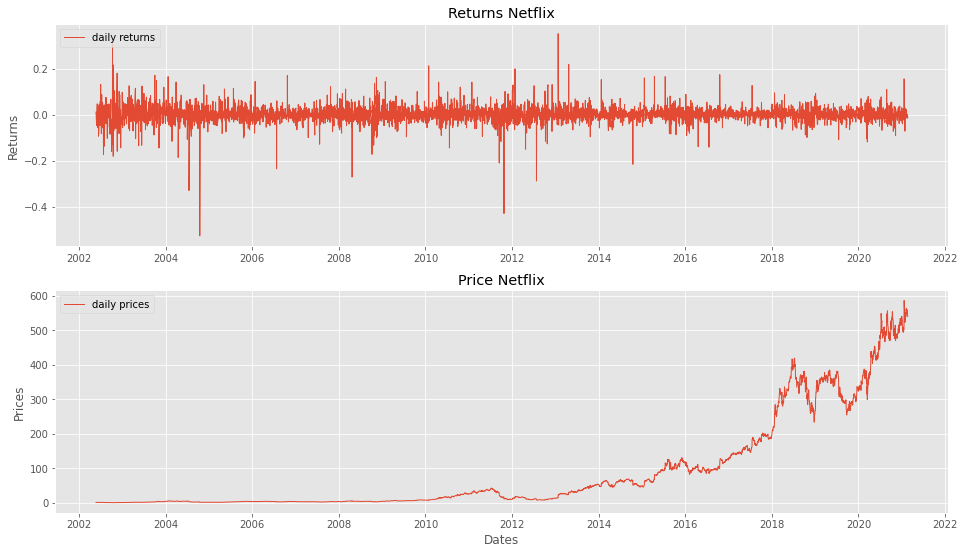

In [ ]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(16,9))
ax1.set_title("Returns " + "Netflix")
ax1.plot(Stock['returns'],label = 'daily returns',linewidth = 1.0)
ax1.set_ylabel('Returns')
ax1.legend(loc='upper left')
ax1.grid(b=True)
ax2.set_title("Price " + "Netflix")
ax2.plot(Stock['Adj Close'],label = 'daily prices',linewidth = 1.0)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Prices')
ax2.legend(loc='upper left')
ax2.grid(b=True)

On entraine notre LSTM à chaque pas de temps pour génerer un backtest de la stratégie sur une période du 10 octobre 2020 à aujourd'hui.

On utilise une periode de Backtest assez courte car le temps de calcul sur toute la profondeur des données nécessite plusieurs heures.

In [ ]:
T = 60
Train_size = 400
Horiz_frct = 1
prediction = list()
pred_dates = list()

for i in tqdm(range(Stock.shape[0]-500,Stock.shape[0]-1-Train_size,Horiz_frct)):
    print(i)
    training_set = Stock.iloc[i:Train_size+i+1, 6:7].values
    test_set = Stock.iloc[Train_size+i:Train_size+i+1, 6:7].values

    #sc = MinMaxScaler(feature_range = (0, 1))
    #training_set_scaled = sc.fit_transform(training_set)
    training_set_scaled = training_set
    # Creating a data structure with 60 time-steps and 1 output
    X_train = []
    y_train = []
    for j in range(T,Train_size):
        X_train.append(training_set_scaled[j-T:j])
        y_train.append(training_set_scaled[j])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 20, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 20, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 20, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 20))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the LSTM
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the LSTM to the Training set
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    model.fit(X_train, y_train, epochs = 35, batch_size = 32,callbacks=[callback]);
    for  k in range(Horiz_frct):
        inputs = Stock.iloc[i+k:Train_size+i+k, 6:7].values
        #inputs = inputs.reshape(-1,1)
        #inputs = sc.transform(inputs)
        X_test = np.array(inputs)
        X_test = np.reshape(X_test, (X_test.shape[1], X_test.shape[0],1))
        predicted_stock_price = model.predict(X_test)
        print(predicted_stock_price)
        #predicted_stock_price = sc.inverse_transform(predicted_stock_price)
        prediction.append(np.float(predicted_stock_price))
        pred_dates.append(Stock.index[Train_size+i+k])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


4218
Epoch 1/35
11/11 [==============================] - 7s 84ms/step - loss: 7.8716e-04
Epoch 2/35
11/11 [==============================] - 1s 88ms/step - loss: 7.7836e-04
Epoch 3/35
11/11 [==============================] - 1s 79ms/step - loss: 7.8628e-04
Epoch 4/35
11/11 [==============================] - 1s 80ms/step - loss: 7.1585e-04
Epoch 5/35
11/11 [==============================] - 1s 83ms/step - loss: 7.6668e-04
Epoch 6/35
11/11 [==============================] - 1s 80ms/step - loss: 7.7312e-04
Epoch 7/35
11/11 [==============================] - 1s 84ms/step - loss: 7.8697e-04
Epoch 8/35
11/11 [==============================] - 1s 83ms/step - loss: 7.8044e-04
[[-0.00088993]]
4219
Epoch 1/35
11/11 [==============================] - 7s 78ms/step - loss: 7.8948e-04
Epoch 2/35
11/11 [==============================] - 1s 79ms/step - loss: 7.2018e-04
Epoch 3/35
11/11 [==============================] - 1s 81ms/step - loss: 7.5810e-04
Epoch 4/35
11/11 [==============================] 

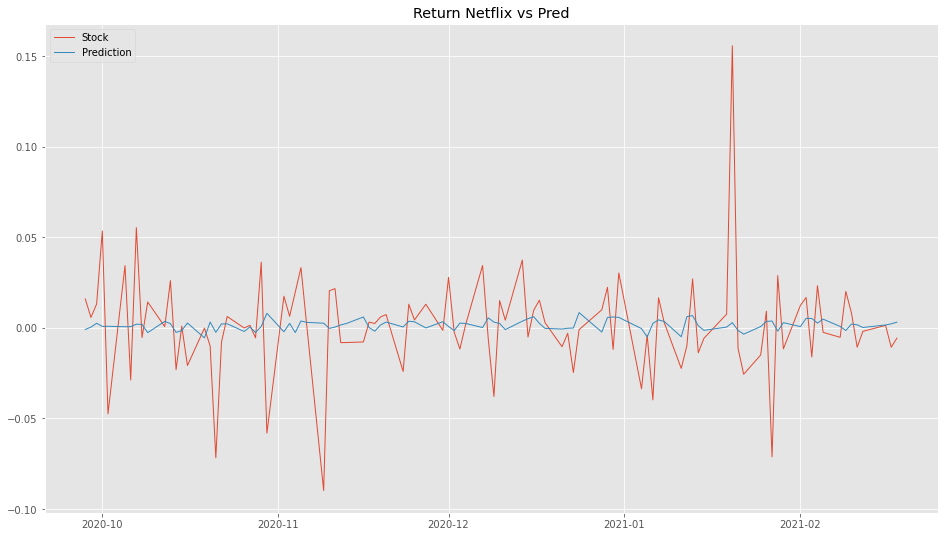

In [ ]:
Lb = int(np.where(Stock.index ==  pred_dates[0])[0])
Hb = int(np.where(Stock.index ==  pred_dates[-1])[0])
# Visualising the results
fig,ax1 = plt.subplots(1, 1, figsize=(16,9))
ax1.set_title("Return Netflix vs Pred")
ax1.grid(b=True)
ax1.plot(Stock['returns'][Lb:Hb+1],label = "Stock" , linewidth = 1.0)
ax1.plot(pred_dates,prediction,label = "Prediction" , linewidth = 1.0)
ax1.legend(loc='upper left')

On note que les rendements issue du LSTM ne fittent pas bien des amplitudes a chaque pas de temps mais le signe reste la plus part du temps cohérent avec la série historique

In [ ]:
results = pd.DataFrame({'returns': list(Stock['returns'][Lb:Hb+1]), 'forecat': prediction },index = pred_dates )
#results['forecat'] = results.forecat.shift(1) ; results = results.dropna()
results

,returns,forecat
2020-09-28,0.015963,-0.000890
2020-09-29,0.005751,0.000441
2020-09-30,0.013186,0.002530
2020-10-01,0.053500,0.000803
2020-10-02,-0.047458,0.000870
...,...,...
2021-02-11,-0.010703,0.001690
2021-02-12,-0.001921,0.000200
2021-02-16,0.001365,0.001601
2021-02-17,-0.010716,0.002229


In [ ]:
def Strat_LSTM(results):
  pos = [1 if results['forecat'][i]>0 else 0 for i in range(results.shape[0])]
  df = pd.DataFrame({'Roll': pos}, index = results.index)
  roll = pd.concat([results, df],axis = 1)
  return roll

In [ ]:
strat = Strat_LSTM(results);

In [ ]:
def plot_perfs(strat):
  fig, (ax1) = plt.subplots(1, 1, figsize=(15,7))

  portfolio_ret = strat['returns']*strat['Roll']

  ax1.plot(strat.index, 1*(1+portfolio_ret.values).cumprod(),label='Strat ret',linewidth = 1.5)
  ax1.plot(strat.index,1*(1+strat['returns'].values).cumprod(),label='Index ret',linewidth = 1.5)
  ax1.set_ylabel('Cumulative returns')
  ax1.set_xlabel('Time')
  ax1.set_title('Returns forecasting Strategy')
  ax1.grid(b = True)
  ax1.legend(loc='best')

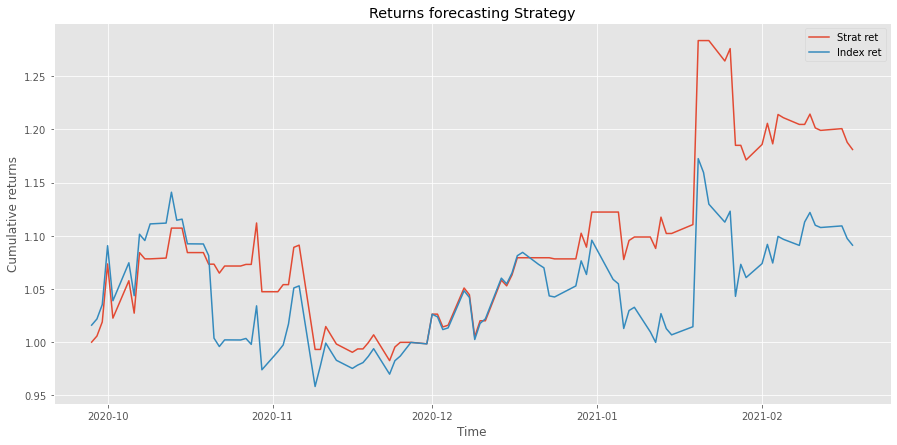

In [ ]:
plot_perfs(strat)

On obtient une stratégie qui surperforme l'actif sur cette fenêtre de temps mais reste neamoins assez proche des performance du titre.On notera que les performance sur cette fenetre de temps ne representent en aucun cas un preuve formelle de la performance de la strategie sur une autre période.

## Stratégie 3 -

Dans cette section nous allons utliser l'ensemble des news sur le Stock Google et utiliser l'analyse de sentiments comme signal d'achat ou de vente.

- A chaque news est associée une date et un sentiment deja detemerminé dans le cas du dataset d'entrainement . Chaque news est noté $-1$ si la news renseigne d'une information negativee , $0$ si elle est neutre et $1$ si elle est postive.

- Notre strategie se base directement sur les sentiments des news comme signal d'achat ou de vente.Dans le cas ou le sentiment est postif on achéte le titre , dans les deux autres cas on sort de la position.

Une premiére methode est d'utiliser les news possedant deja un label pour determiner si elles sont un indicateur pertinent.Ensuite nous utiliserons un Random Forest pour prédire le sentiment sur des news qui serviront de nouvelle base pour identifier des signaux . 



In [ ]:
Stock = yf.download("GOOGL") ; Stock = Stock.dropna()
asset_log_returns = pd.DataFrame(data = np.log(Stock['Adj Close']).diff().dropna())
Stock = Stock.drop(Stock.index[0], axis=0) ; 
Stock['returns'] = asset_log_returns.values
print('Number of rows and columns:', Stock.shape)
dates = Stock.index.to_native_types().tolist();dates = [datetime.datetime.strptime(x,'%Y-%m-%d') for x in dates]
Stock['Dates'] = dates ;# Stock = Stock.set_index('Dates')
Stock

[*********************100%***********************]  1 of 1 completed
Number of rows and columns: (4154, 7)


,Open,High,Low,Close,Adj Close,Volume,returns,Dates
Date,,,,,,,,
2004-08-20,50.555557,54.594597,50.300301,54.209209,54.209209,22834343,0.076433,2004-08-20
2004-08-23,55.430431,56.796799,54.579578,54.754753,54.754753,18256126,0.010013,2004-08-23
2004-08-24,55.675674,55.855858,51.836838,52.487488,52.487488,15247337,-0.042289,2004-08-24
2004-08-25,52.532532,54.054054,51.991993,53.053055,53.053055,9188602,0.010718,2004-08-25
2004-08-26,52.527527,54.029030,52.382381,54.009010,54.009010,7094898,0.017858,2004-08-26
...,...,...,...,...,...,...,...,...
2021-02-12,2079.770020,2099.500000,2073.570068,2095.030029,2095.030029,948500,0.003002,2021-02-12
2021-02-16,2091.750000,2145.139893,2091.750000,2110.699951,2110.699951,1548900,0.007452,2021-02-16
2021-02-17,2093.979980,2122.439941,2088.350098,2118.620117,2118.620117,1014700,0.003745,2021-02-17


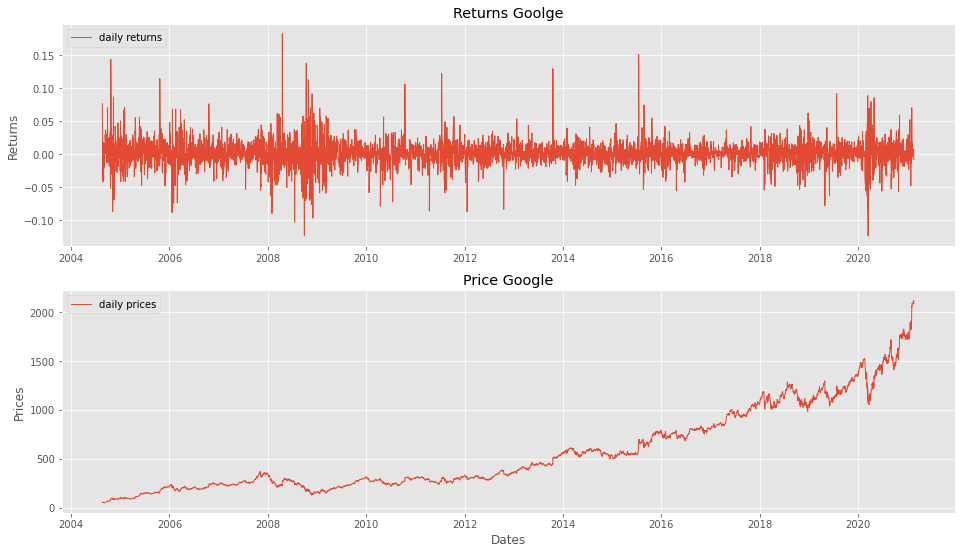

In [ ]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(16,9))
ax1.set_title("Returns " + "Goolge")
ax1.plot(Stock['returns'],label = 'daily returns',linewidth = 1.0)
ax1.set_ylabel('Returns')
ax1.legend(loc='upper left')
ax1.grid(b=True)
ax2.set_title("Price " + "Google")
ax2.plot(Stock['Adj Close'],label = 'daily prices',linewidth = 1.0)
ax2.set_xlabel('Dates')
ax2.set_ylabel('Prices')
ax2.legend(loc='upper left')
ax2.grid(b=True)

Chargement d'un csv de news 

In [ ]:
# Import the required packages: 
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re 

def return_git_csv_files(url):

  # Issue request: r => requests.models.Response
  r = requests.get(url)

  # Extract text: html_doc => str
  html_doc = r.text

  # Parse the HTML: soup => bs4.BeautifulSoup
  soup = BeautifulSoup(html_doc)

  # Find all 'a' tags (which define hyperlinks): a_tags => bs4.element.ResultSet
  a_tags = soup.find_all('a')

  # Store a list of urls ending in .csv: urls => list
  urls = ['https://raw.githubusercontent.com'+re.sub('/blob', '', link.get('href')) 
          for link in a_tags  if '.csv' in link.get('href')]

  # Store a list of Data Frame names to be assigned to the list: df_list_names => list
  df_list_names = [url.split('.csv')[0].split('/')[url.count('/')] for url in urls]

  # Initialise an empty list the same length as the urls list: df_list => list
  df_list = [pd.DataFrame([None]) for i in range(len(urls))]

  # Store an empty list of dataframes: df_list => list
  df_list = [pd.read_csv(url, sep = ',') for url in urls]

  # Name the dataframes in the list, coerce to a dictionary: df_dict => dict
  df_dict = dict(zip(df_list_names, df_list))
  return df_dict# Import the required packages: 
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re 

def return_git_csv_files(url):

  # Issue request: r => requests.models.Response
  r = requests.get(url)

  # Extract text: html_doc => str
  html_doc = r.text

  # Parse the HTML: soup => bs4.BeautifulSoup
  soup = BeautifulSoup(html_doc)

  # Find all 'a' tags (which define hyperlinks): a_tags => bs4.element.ResultSet
  a_tags = soup.find_all('a')

  # Store a list of urls ending in .csv: urls => list
  urls = ['https://raw.githubusercontent.com'+re.sub('/blob', '', link.get('href')) 
          for link in a_tags  if '.csv' in link.get('href')]

  # Store a list of Data Frame names to be assigned to the list: df_list_names => list
  df_list_names = [url.split('.csv')[0].split('/')[url.count('/')] for url in urls]

  # Initialise an empty list the same length as the urls list: df_list => list
  df_list = [pd.DataFrame([None]) for i in range(len(urls))]

  # Store an empty list of dataframes: df_list => list
  df_list = [pd.read_csv(url, sep = ',') for url in urls]

  # Name the dataframes in the list, coerce to a dictionary: df_dict => dict
  df_dict = dict(zip(df_list_names, df_list))
  return df_dict

In [ ]:
keys = ['stock']
urls = {'stock' : 'https://github.com/federico2001/google_stock_prediction/tree/master/google_data'}

data = {}
for i in keys:
  data[i] = return_git_csv_files(urls[i])


In [ ]:
news_labeled = data['stock']['labeled_news']
news_unlabeled = data['stock']['unlabled_news']

In [ ]:
news_unlabeled[(news_unlabeled['sentiment'].values >0) & (news_unlabeled['sentiment'].values < 0)]
# Les données sont bien unlabeled ; les 0 sint mits pas defaults

,Unnamed: 0,timestamp,WALL_STREE.text_COUNT_pre_post1days:google,WALL_STREE.text_pre_post1days:google,date,news_list,news_count,sentiment


In [ ]:
news_labeled[news_labeled.news_count > 0][['date','news_list', 'sentiment']]

,date,news_list,sentiment
24,24.01.2017 18:00:00,['google has a messaging app problem'],-1.0
26,26.01.2017 18:00:00,['google parent alphabet reports jump in earni...,1.0
28,28.01.2017 18:00:00,['google chief sundar pichai criticizes trump ...,0.0
32,01.02.2017 18:00:00,['the cloud public private hybridwhats best fo...,0.0
36,05.02.2017 18:00:00,['tech giants could make visa reform work'],1.0
...,...,...,...
1346,08.09.2020 19:00:00,"['ex-google ceo eric schmidt and his wife, wen...",0.0
1368,30.09.2020 19:00:00,['google announced a new generation of mobile ...,1.0
1369,01.10.2020 19:00:00,['facebooks mark zuckerbeg twitters jack dorse...,0.0
1370,02.10.2020 19:00:00,"['amazon on thursday said more than 19,000 of ...",0.0


In [ ]:
import datetime
def plot_sentiments(Stock,news_labeled):
  line_size = 0.5

  sentiment = news_labeled[news_labeled.news_count > 0][['date','news_list', 'sentiment']]
  sentiment_pos = sentiment[sentiment.sentiment > 0]
  sentiment_neg = sentiment[sentiment.sentiment < 0]
  fig, (ax1) = plt.subplots(1, 1,figsize=(16,9))
  ax1.set_title("Stock price and Tweets signals " + "Goolge")
  ax1.plot(Stock['Adj Close'],label = 'daily prices',linewidth = 1.0)
  ax1.grid(b=True)
  for i in range(sentiment_pos['date'].shape[0]):
    ax1.axvline(datetime.datetime.strptime(sentiment_pos['date'].values[i], '%d.%m.%Y %H:%M:%S'),color='g',linewidth = line_size)
  for i in range(sentiment_neg['date'].shape[0]):
    ax1.axvline(datetime.datetime.strptime(sentiment_neg['date'].values[i], '%d.%m.%Y %H:%M:%S'),color='red',linewidth = line_size)
  ax1.set_ylabel('Cumulative returns')
  ax1.set_xlim(datetime.datetime.strptime(sentiment['date'].values[0], '%d.%m.%Y %H:%M:%S'),datetime.datetime.strptime(sentiment['date'].values[-1], '%d.%m.%Y %H:%M:%S'))
  ax1.legend(loc='best')
  plt.show()

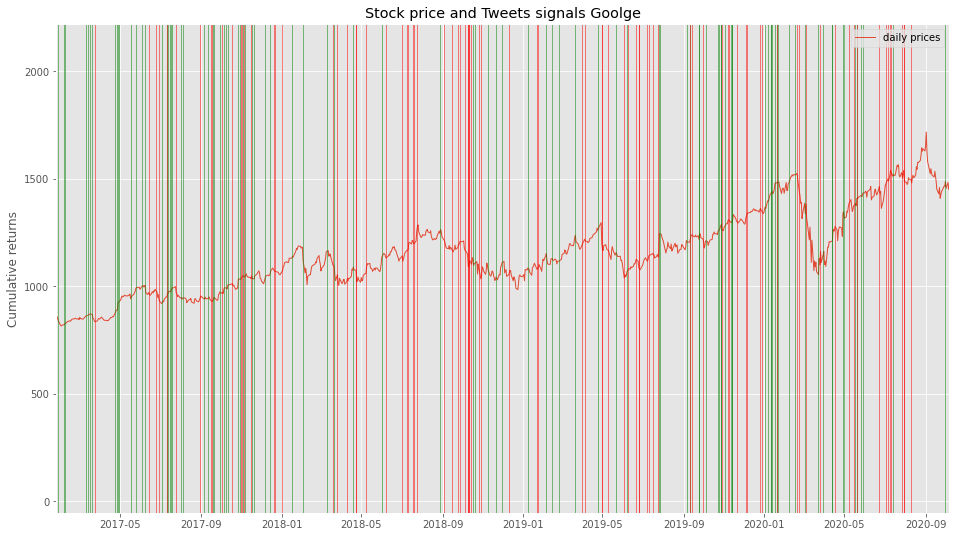

In [ ]:
plot_sentiments(Stock,news_labeled)

On definie un premiere strategie sur les news labeled avant d'introduire l'erreur de prediction de l'algorithme.

In [ ]:
def Strat_News(Stock,news_labeled):

  sentiment = news_labeled[news_labeled.news_count > 0][['date','news_list', 'sentiment']]
  dates = [datetime.datetime.strptime(x,'%d.%m.%Y %H:%M:%S') for x in sentiment['date']] ; sentiment['date'] = dates 
  #sentiment_pos = sentiment[sentiment.sentiment > 0]
  #sentiment_neg = sentiment[sentiment.sentiment < 0]
  Init_date = sentiment['date'].values[0] ; End_date = sentiment['date'].values[-1]
  wdw_Stock = Stock[(Stock['Dates'].values> np.datetime64(Init_date))  & (Stock['Dates'].values < np.datetime64(End_date))]
  pos = pd.DataFrame(columns=['date','pos']) ; pos = pos.append({'date' :  wdw_Stock['Dates'].values[0] , 'pos' : 1}, ignore_index=True)
  for i in range(wdw_Stock.shape[0]-1) :
    date = wdw_Stock['Dates'].values[i] ; date_post = wdw_Stock['Dates'].values[i+1]
    news  = sentiment[(sentiment['date'].values> np.datetime64(date))  & (sentiment['date'].values < np.datetime64(date_post))]
    if news.shape[0] != 0:
      if sum(news['sentiment'].values)  > 0:
        decision = 1
      if sum(news['sentiment'].values)  < 0:
        decision = -1
      else:
        decision = 0
    else :
      
      decision = pos['pos'].values[i]

    pos = pos.append({'date' : date_post , 'pos' : decision}, ignore_index=True)
  wdw_Stock['pos'] = pos['pos'].values

  return wdw_Stock


In [ ]:
Strat = Strat_News(Stock,news_labeled)
Strat

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,Adj Close,Volume,returns,Dates,pos
Date,,,,,,,,,
2017-01-25,853.549988,858.789978,849.739990,858.450012,858.450012,1655400,0.010445,2017-01-25,1
2017-01-26,859.049988,861.000000,850.520020,856.979980,856.979980,3493300,-0.001714,2017-01-26,1
2017-01-27,859.000000,867.000000,841.900024,845.030029,845.030029,3752500,-0.014042,2017-01-27,0
2017-01-30,837.059998,837.229980,821.030029,823.830017,823.830017,3516900,-0.025408,2017-01-30,0
2017-01-31,819.500000,823.070007,813.400024,820.190002,820.190002,2020200,-0.004428,2017-01-31,0
...,...,...,...,...,...,...,...,...,...
2020-09-30,1460.939941,1486.199951,1455.760010,1465.599976,1465.599976,2046200,-0.000287,2020-09-30,0
2020-10-01,1483.660034,1495.069946,1476.800049,1487.900024,1487.900024,1644200,0.015101,2020-10-01,0
2020-10-02,1459.630005,1479.030029,1447.349976,1455.599976,1455.599976,1561100,-0.021948,2020-10-02,0


In [ ]:
def Strat_Returns(Strat):
  ret = Strat['returns'].values * Strat['pos'].values
  retcumules = (1+ret).cumprod()
  return retcumules

In [ ]:
Strat_Returns(Strat);

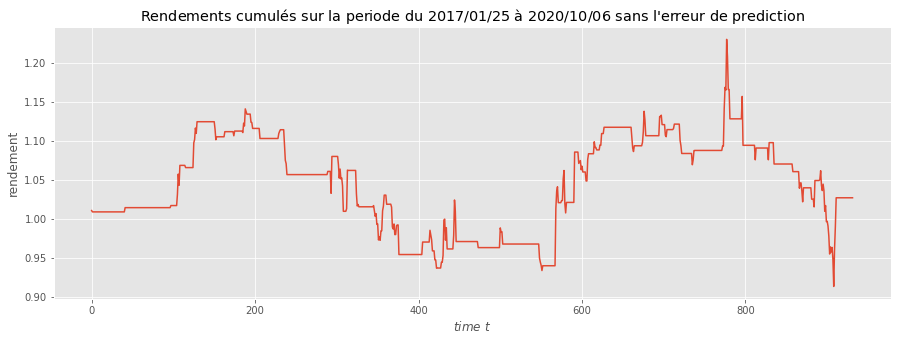

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set(title="Rendements cumulés sur la periode du $2017/01/25$ à $2020/10/06$ sans l'erreur de prediction", xlabel="$time\ t$", ylabel="rendement")
ax.plot(Strat_Returns(Strat));

On observe sur le graphique des zones planes correspondant à des intervalles de temps ou on ne se postionne pas sur l'actif.C'est en partie dû au fait qu'il y a moins de news que de jours.D'autre part les signaux donnés par les news ne semblent pas etre trés pertinents.

Nous allons maintenant utiliser un alogrithme de NLP pour faire de l'analyse de sentiment sur des news unlabeled .

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [ ]:
labeled_news = []

for index, row in news_labeled[news_labeled.news_count > 0][['date','news_list', 'sentiment']].iterrows():
    for text in literal_eval(row['news_list']):
        labeled_news.append({'text' : text, 'sentiment' : row['sentiment']})

labeled_news_df = pd.DataFrame(labeled_news)

labeled_news_df

,text,sentiment
0,google has a messaging app problem,-1.0
1,google parent alphabet reports jump in earnings,1.0
2,google chief sundar pichai criticizes trump ov...,0.0
3,google ceo sundar pichai criticized trumps imm...,0.0
4,the cloud public private hybridwhats best for ...,0.0
...,...,...
517,"ex-google ceo eric schmidt and his wife, wendy...",0.0
518,google announced a new generation of mobile an...,1.0
519,facebooks mark zuckerbeg twitters jack dorsey ...,0.0
520,"amazon on thursday said more than 19,000 of it...",0.0


In [ ]:
corpus = list(labeled_news_df.text)
vectorizer = TfidfVectorizer(ngram_range = (1,2), stop_words = 'english', min_df = 2)
X = vectorizer.fit_transform(corpus)
df_tokenized_news = pd.DataFrame.sparse.from_spmatrix(X, columns = vectorizer.get_feature_names())
df_sentiment = pd.concat([labeled_news_df, df_tokenized_news], axis = 1)
print(df_sentiment.shape)

(522, 1552)


In [ ]:
corrs = df_sentiment.corr()['sentiment'].sort_values()
corrs[:20]
corrs[-20:]

alphabets waymo     0.111567
drones              0.112299
300                 0.113114
europe              0.113325
alphabet posted     0.113600
push                0.113657
millions patient    0.113748
patient             0.113748
computer            0.114676
offers              0.115627
strong              0.116078
alphabets           0.119995
worlds              0.124476
service             0.125878
google cloud        0.128677
records             0.135280
court               0.135903
cloud               0.141266
millions            0.144119
sentiment           1.000000
Name: sentiment, dtype: float64

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [ ]:
df_sentiment.select_dtypes(['number'])  

,sentiment,10,10000,10000 years,11,13,13 billion,131,131 countries,18,19,20,2016,2016 presidential,2021,2021 people,21,24,25,30,300,300 entertainment,317,317 million,33,34,34 billion,500,5g,ability,access,access suppliers,according,according wsj,account,accusations,accused,accused google,acquisition,act,...,wildly,wildly profitable,wind,wind solar,women,wont,woo,work,workers,workforce,working,works,world,world instead,world wide,worlds,worlds fastest,writes,writes allysiafinley,writes holmanjenkins,writes newsceo,wsj,wsj investigation,wsjheard,wsjopinion,wsjs,wsjs joannastern,wsjwhatsnow,wsjwhatsnowpic_twitter_com,year,year bought,years,years perform,youll,youll notice,young,youtube,youtube channels,youve,youve served
0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
518,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.266384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.239606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [ ]:
target = 'sentiment'

# First, for POSITIVES

# Drop non numerics
df = df_sentiment.dropna(axis=1).select_dtypes(['number'])  
#df[target] = [1 if val > 0 else 0 for val in df[target]]

df_train, df_test = train_test_split(df, test_size = 0.05)

#df_train = balanceDf(df_train, target)#.dropna(axis=1).select_dtypes(['number'])

# Create train/test sets
X_train = df_train.loc[:, df_train.columns != target].values
y_train = df_train.loc[:,[target]].values

X_test = df_test.loc[:, df_test.columns != target].values
y_test = df_test.loc[:,[target]].values

print('Train Shape:')
print(X_train.shape)
print(y_train.shape) 
print('Test Shape:')
print(X_test.shape)
print(y_test.shape) 

#Random forest model specification
model =  RandomForestClassifier(n_estimators = 1000)
# Train on data
model.fit(X_train, y_train.ravel())
model_score = cross_val_score(model, X_train, y_train.ravel(), cv=5)
print("=== All Scores ===")
print(model_score)

Train Shape:
(495, 1550)
(495, 1)
Test Shape:
(27, 1550)
(27, 1)
=== All Scores ===
[0.58585859 0.5959596  0.58585859 0.51515152 0.61616162]


In [ ]:
y_pred_random = model.predict(X_test)
#preds = [1 if val > 0.5 else 0 for val in y_pred_random]
y_test_d = y_test.ravel()

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test_d,y_pred_random ))
print(classification_report(y_test_d,y_pred_random ))
print(accuracy_score(y_test_d,y_pred_random ))

[[ 4  6  0]
 [ 1 13  1]
 [ 0  2  0]]
              precision    recall  f1-score   support

        -1.0       0.80      0.40      0.53        10
         0.0       0.62      0.87      0.72        15
         1.0       0.00      0.00      0.00         2

    accuracy                           0.63        27
   macro avg       0.47      0.42      0.42        27
weighted avg       0.64      0.63      0.60        27

0.6296296296296297


On voit que l'accuracy de notre modele seulement de 63%.Cette erreur est particuliérement liée au dataset d'entrainement trops petit avec seulement 522 samples.D'autre part le Random forest ne prend pas compte l'ordre des mots dans la phrase ce qui limite grandement son efficacité.

Nous pourrions à la place du Random Forest Utiliser un LSTM ou BERT l'algorithme devloppé par Google.

In [ ]:
df_anchor = news_unlabeled 

In [ ]:
df_anchor

,Unnamed: 0,timestamp,WALL_STREE.text_COUNT_pre_post1days:google,WALL_STREE.text_pre_post1days:google,date,news_list,news_count,sentiment
0,0,1483228800,0,[],31.12.2016 18:00:00,[],0,0
1,1,1483315200,0,[],01.01.2017 18:00:00,[],0,0
2,2,1483401600,0,[],02.01.2017 18:00:00,[],0,0
3,3,1483488000,0,[],03.01.2017 18:00:00,[],0,0
4,4,1483574400,0,[],04.01.2017 18:00:00,[],0,0
...,...,...,...,...,...,...,...,...
1378,1378,1602374400,0,[],10.10.2020 19:00:00,[],0,0
1379,1379,1602460800,0,[],11.10.2020 19:00:00,[],0,0
1380,1380,1602547200,0,[],12.10.2020 19:00:00,[],0,0
1381,1381,1602633600,0,[],13.10.2020 19:00:00,[],0,0


In [ ]:
df_anchor[df_anchor['WALL_STREE.text_COUNT_pre_post1days:google'] > 0]['news_list']

24                 ['google has a messaging app problem']
26      ['google parent alphabet reports jump in earni...
28      ['google chief sundar pichai criticizes trump ...
32      ['the cloud public private hybridwhats best fo...
36            ['tech giants could make visa reform work']
                              ...                        
1346    ['ex-google ceo eric schmidt and his wife, wen...
1368    ['google announced a new generation of mobile ...
1369    ['facebooks mark zuckerbeg twitters jack dorse...
1370    ['amazon on thursday said more than 19,000 of ...
1374    ['a house panel urged congress to force amazon...
Name: news_list, Length: 407, dtype: object

In [ ]:
# Lets separate every text with the sentiment
## It s taking 3 minutes 

sentiment_est = []

for index, row in df_anchor[['WALL_STREE.text_COUNT_pre_post1days:google','WALL_STREE.text_pre_post1days:google']].iterrows():
    if row['WALL_STREE.text_COUNT_pre_post1days:google'] > 0:
        corpus = row['WALL_STREE.text_pre_post1days:google']
        if len(corpus) > 0 :
            corpus = [corpus]
            X = vectorizer.transform(corpus)
            df_tokenized_news = pd.DataFrame.sparse.from_spmatrix(X, columns = vectorizer.get_feature_names())
            df_test = df_tokenized_news.dropna(axis=1).select_dtypes(['number'])
            X_test = df_test.loc[:, df_test.columns != target].values
            sentiment_est.append(model.predict(X_test).mean())
        else:
            sentiment_est.append(0)
    else:
        sentiment_est.append(0)

In [ ]:
df_anchor['sentiment'] = sentiment_est
df_anchor['sentiment'] = [1 if val > 0 else -1 if val<0 else 0 for val in df_anchor['sentiment']]
test_set = df_anchor[df_anchor.news_count > 0][['date','news_list', 'sentiment']]
test_set

,date,news_list,sentiment
24,24.01.2017 18:00:00,['google has a messaging app problem'],-1
26,26.01.2017 18:00:00,['google parent alphabet reports jump in earni...,1
28,28.01.2017 18:00:00,['google chief sundar pichai criticizes trump ...,0
32,01.02.2017 18:00:00,['the cloud public private hybridwhats best fo...,0
36,05.02.2017 18:00:00,['tech giants could make visa reform work'],1
...,...,...,...
1346,08.09.2020 19:00:00,"['ex-google ceo eric schmidt and his wife, wen...",0
1368,30.09.2020 19:00:00,['google announced a new generation of mobile ...,1
1369,01.10.2020 19:00:00,['facebooks mark zuckerbeg twitters jack dorse...,0
1370,02.10.2020 19:00:00,"['amazon on thursday said more than 19,000 of ...",0


In [ ]:
sentiment = test_set
Init_date = sentiment['date'].values[0] ; End_date = sentiment['date'].values[-1]
dates = [datetime.datetime.strptime(str(x),'%d.%m.%Y %H:%M:%S') for x in sentiment['date'].values] ; sentiment['date'] = dates 
Init_date = sentiment['date'].values[0] ; End_date = sentiment['date'].values[-1]

In [ ]:
wdw_Stock = Stock[(Stock['Dates'].values> np.datetime64(Init_date))  & (Stock['Dates'].values < np.datetime64(End_date))]
pos = pd.DataFrame(columns=['date','pos']) ; pos = pos.append({'date' :  wdw_Stock['Dates'].values[0] , 'pos' : 1}, ignore_index=True)
for i in range(wdw_Stock.shape[0]-1) :
  date = wdw_Stock['Dates'].values[i] ; date_post = wdw_Stock['Dates'].values[i+1]
  news  = sentiment[(sentiment['date'].values> np.datetime64(date))  & (sentiment['date'].values < np.datetime64(date_post))]
  if news.shape[0] != 0:
    if sum(news['sentiment'].values)  > 0:
      decision = 1
    if sum(news['sentiment'].values)  < 0:
      decision = -1
    else:
      decision = 0
  else :
    
    decision = pos['pos'].values[i]

  pos = pos.append({'date' : date_post , 'pos' : decision}, ignore_index=True)
wdw_Stock['pos'] = pos['pos'].values
Strat = wdw_Stock

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
def Strat_Returns(Strat):
  ret = Strat['returns'].values * Strat['pos'].values
  retcumules = (1+ret).cumprod()
  return retcumules

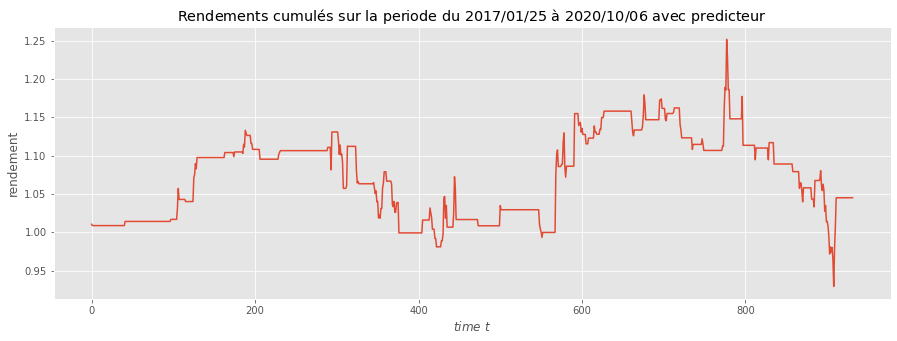

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set(title="Rendements cumulés sur la periode du $2017/01/25$ à $2020/10/06$ avec predicteur", xlabel="$time\ t$", ylabel="rendement")
ax.plot(Strat_Returns(Strat));

On obtient un graphique porche du precedent avec le predicteur.Les signaux identifiés ne correspondent donc pas a des jours a fort rendement  

## Stratégie Bonus - Google Trend Crise

- L'idée ici est de se constituer un portefeuille de titres suceptible de baisser fortement en temps de crise, sanitaire ou économique. Essayer de capter un moment de crise avec Google Trend, et de shorter les actifs en même temps en fonction de leurs catégories.

- Notre stratégie consiste a repérer l'intérêt pour les mots "crisis", "krach", "virus", et de shorter les actifs dont la catégorie y est sensible pendant le temps ou le score correspondant est supérieur au seuil de $90$ (short d'un mois minimum vu que nous gardons le même score pour chaque mois).

- Note : cette stratégie est laissée en bonus car n'est vraiment pas éthique.

- Voici notre univers d'investissement :  

  - Loisirs (Cineworld Group, Tokyo Theatres Comp) | Sensibilité : "virus"
  - Tourisme (Air France-KLM, EasyJet, InterContinental Hotels) | Sensibilité : "virus"
  - Indices Equity (CAC40, S&P500) (on suppose qu'on peut traiter directement l'index) | Sensibilité : "virus", "krach, "crisis"

- Nous afficherons la somme cumulée des logs-rendements en guise de performance.

- On note que les signaux "krach" et "crise" peuvent arriver en meme temps, nous avons choisi de shorter deux fois plus en conséquence et de ne pas prendre qu'un seul des deux signaux.

In [ ]:
%%capture
# Notre univers d'investissment 
univers = dict({"CineWorld":["CINE.L", "Loisirs"],
                "Tokyo Theatre":["9633.T", "Loisirs"],
                "Air France":["AF.PA", "Tourisme"],
                "EasyJet":["EZJ.L","Tourisme"],
                "InterCont Hotels":["IHG","Tourisme"],
                "CAC40":["^FCHI","EquityIndex"],
                "SP500":["^GSPC","EquityIndex"]})

univers = pd.DataFrame(univers).transpose().rename({0:"Ticker",1:"Categories"}, axis=1)

# Mapping de sensibilités
sensibility = dict({"Loisirs":["virus"],"Tourisme":["virus"],"EquityIndex":["virus","crisis","krach"]})

# Nos données financières
shortable = pd.DataFrame()
for index, row in univers.iterrows():
  data = yf.download(row.Ticker)["Adj Close"].rename(index)
  log_r = pd.Series(np.log(data).diff()).rename(f"log_r_{index}") # Ils seront recalculés pour la somme selon les facteurs
  shortable = pd.concat([shortable, data, log_r], axis=1)
shortable.dropna(inplace=True)

# Notre table Google Trend d'intérêt de recherche de crise
crise_interest = pd.DataFrame()
for key in ["crisis", "krach", "virus"]:
  trend = TrendReq()
  # On ne peut pas loader tous les keyword ensemble car le scale se ferait sur les trois ensemble (les comparerait), et nous les voulons à part
  trend.build_payload(kw_list=[key], timeframe="all")
  # On load la fonctionnalité "Interest Over Time"
  tojoin = trend.interest_over_time().drop("isPartial", axis=1)
  crise_interest = pd.concat([crise_interest,tojoin[key]], axis=1)
crise_interest.index = pd.to_datetime(crise_interest.index)
crise_interest = crise_interest.resample("D").fillna(method="ffill")

# Notre jeu de données final:
shortable = shortable.join(crise_interest)
shortable.dropna(inplace=True)

In [ ]:
# On affiche notre univers d'investissement
univers

,Ticker,Categories
CineWorld,CINE.L,Loisirs
Tokyo Theatre,9633.T,Loisirs
Air France,AF.PA,Tourisme
EasyJet,EZJ.L,Tourisme
InterCont Hotels,IHG,Tourisme
CAC40,^FCHI,EquityIndex
SP500,^GSPC,EquityIndex


In [ ]:
for factor in crise_interest.columns:
  # Categories sensibles au facteur en cours
  categs = [key for key, val in sensibility.items() if factor in val]
  # On prend les actifs correspondants aux catégories impactées
  assets = list(univers[univers.Categories.isin(categs)].index)
  rlist = [f"log_r_{asset}" for asset in assets]
  # On applique notre indicateur (supérieur à 90)
  x = -1*(shortable[factor] >= 90)
  # On shift
  x = x.shift(1)
  # On somme tous les log rendements des actifs concernés par le facteur
  g = x*(shortable[rlist].sum(axis=1))
  shortable[f"g_{factor}"] = g

# On somme pour avoir le rendement total
shortable["g_tot"] = shortable.loc[:,[f"g_{factor}" for factor in crise_interest.columns]].sum(axis=1)

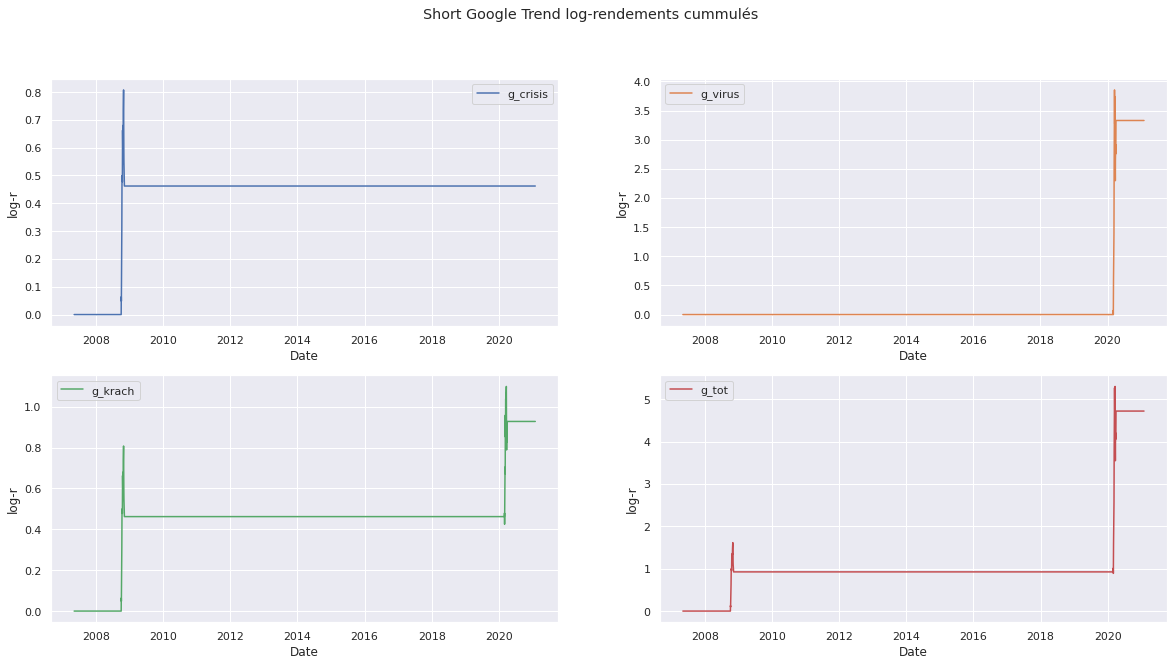

In [ ]:
# On affiche les résultats
fig, ax = plt.subplots(2,2,figsize=(20,10))
shortable.loc[:,["g_crisis", "g_virus", "g_krach", "g_tot"]].cumsum().plot(subplots=True, grid=True, 
                                                                           ax=ax, title="Short Google Trend log-rendements cummulés", legend=True,
                                                                           xlabel="Date", ylabel="log-r");

- Nous voyons donc bien que :
  - pour le keyword Google Trend "crisis", on extrait du signal seulement pour la crise de 2008,
  - pour le keyword Google Trend "krach", on extrait du signal pour la crise de 2008 (exactement les mêmes positions que pour "crisis") et également pour la crise du covid,
  - pour le keyword Google Trend "virus", on extrait du signal seulement pour la crise du covid.

- Tout cela paraît cohérent, à part le fait que "crisis" n'ait pas extrait de signal pour le covid, son score d'intérêt était de $52$ contre $99$ pour "krach" en Mars 2020. Le mot "crisis" est selon nous plus recherché en général, alors que "krach" sera plus recherché pendant les krachs boursiers, d'ou son score plus fort pour 2008 et Mars 2020, alors que le score de "crisis" est plus lissé sur toute la période de notre univers.

- Nous voyons donc que la stratégie est profitable en général. 

- En remarque, nous pouvons dire qu'une amélioration serait de tenir compte de la durée de position. Par exemple, pour le cas "crisis", cela aurait était bien plus profitable si la sortie avait été faite plus tôt (mais ce qui n'est pas le cas pour "virus" !)

- De plus, cette stratégie ne permet clairement pas de générer des rendements réguliers. Elle serait utile pour compenser la perte d'autres stratégies en cas de crise.
